In [47]:
import os
import numpy as np
import pandas as pd
import itertools
import networkx as nx
import copy
import math

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

from aux import *
from visualize import *
from model import *

In [48]:
DATA_PATH = '../Data/'
class_ids = sorted([int(file_name.split('_')[0]) for file_name in os.listdir(DATA_PATH) if file_name.endswith('sex.csv')])

# networks and affective matrices of all classes in wave 1
networks = {}
affective_matrices = {}
for class_id in class_ids:
    networks[class_id] = LoadData2Network(class_id, 1)
    affective_matrices[class_id] = pd.read_csv(DATA_PATH + str(class_id) + '_affective_w1.csv', \
                                               header = 0, index_col = 0)
    

In [49]:
# Game Structure
PAYOFF_FUNCTION = {('tell a secret', 'tell a secret'): (1, 1),
                   ('tell a secret', 'refrain'): (-1, 0),
                   ('refrain', 'tell a secret'): (0, -1),
                   ('refrain', 'refrain'): (0, 0)}

In [55]:
class StudentAgent():
    def __init__(self, model, idx, gender, trust_agents, affective):
        """
        Create a new agent

        Args:
            id: unique identifier for the agent
            gender: female or male
            prob_trust: tendency to trust others (irrespective of gender)
            trust_agents: a set of agent ids which the agent trust
            affective: a dictionary of affective score rated by each agent keyed by id
            strategy: either 'tell a secret' or 'refrain'
        """

        self.model = model
        self.id = idx
        self.gender = gender
        self.trust_agents = trust_agents
        self.prob_trust = len(trust_agents) / len(affective)
        self.affective = affective
        self.strategy = None

    def play(self, opponent):
        if self.gender == 'female':
            bonus_for_gender = self.model.bonus_f2f if self.gender == opponent.gender else 0
        else:
            bonus_for_gender = self.model.bonus_m2m if self.gender == opponent.gender else 0

        bonus_for_friends = self.model.bonus_for_friends if self.affective[opponent.id] == 2 else 0

        prob_cooperate = self.prob_trust + bonus_for_gender + bonus_for_friends \
                         if opponent.id not in self.trust_agents else 1
        if prob_cooperate > 1:
            prob_cooperate = 1

        return np.random.choice(a = ['tell a secret', 'refrain'], p = [prob_cooperate, 1 - prob_cooperate])
    
    def play_logRegression(self, opponent):
        f2f = 1 if self.gender == opponent.gender and self.gender == 'female' else 0
        m2m = 1 if self.gender == opponent.gender and self.gender == 'male' else 0
        affective = self.affective[opponent.id]
        feature = np.array([f2f, m2m, affective]).reshape(1, -1)
        
        prob_cooperate = 0.5 if math.isnan(affective)\
                             else self.model.logRegression.predict_proba(feature)[0][1] 
                             # We use it as a probability to cooperate
        
        return np.random.choice(a = ['tell a secret', 'refrain'], p = [prob_cooperate, 1 - prob_cooperate]) 

    def state_update(self):
        self.prob_trust = len(self.trust_agents) / len(self.affective)

In [59]:
class TrustModel():
    def __init__(self, trust_network, affective_matrix, \
                 bonus_m2m, bonus_f2f, bonus_for_friends):
        """
        Args:
            trust_network: A networkx DiGraph. Edge (A, B) exists iff A trusts B
            affective_matrix: A pandas dataframe that has the affective scores from all agents to all agents
            bonus_m2m: normalized assortativity coefficient (male, male) interpreted as probability
            bonus_f2f: normalized assortativity coefficient (female, female) interpreted as probability
            bonus_for_friends: Correlation coefficient between friends and trust
            simulated_networks: a list of all simulated networks
        """

        self.trust_network = copy.deepcopy(trust_network)
        self.affective_matrix = copy.deepcopy(affective_matrix)
        self.bonus_m2m = bonus_m2m
        self.bonus_f2f = bonus_f2f
        self.bonus_for_friends = bonus_for_friends
        self.agents = []
        self.simulated_networks = [copy.deepcopy(trust_network)]
        
        features, trust_vec = self.__preprocessing()
        self.logRegression = LogisticRegression(random_state=0, \
                                                 solver='lbfgs', multi_class='multinomial').fit(features, trust_vec)

        for idx, attributes in self.trust_network.nodes(data = True):
            trust_agents = [n for n in trust_network.neighbors(idx)]
            # Initialize the affective scores from one agent (= id) to all other agents
            affective = {}
            for column_idx in affective_matrix.loc[[idx]]:
                affective[int(column_idx)] = affective_matrix.loc[[idx]][column_idx].values[0]
            self.agents.append(StudentAgent(self, idx, attributes['sex'], set(trust_agents), affective))
            

    def step(self):
        """
        At each time step all pairs of agent will interact and play prisoner's dilemma once
        """

        ## Update affective_matrix according the payoff function
        for a, b in itertools.combinations(self.agents, 2):
            strategy = (a.play_logRegression(b), b.play_logRegression(a))
            a_payoff, b_payoff = PAYOFF_FUNCTION[strategy]
            a.affective[b.id] += a_payoff
            b.affective[a.id] += b_payoff

            if a.affective[b.id] > 2:
                a.affective[b.id] = 2 
            if a.affective[b.id] < -2:
                a.affective[b.id] = -2

            if b.affective[a.id] > 2:
                b.affective[a.id] = 2 
            if b.affective[a.id] < -2:
                b.affective[a.id] = -2 

            self.affective_matrix[str(a.id)][b.id] = a.affective[b.id]
            self.affective_matrix[str(b.id)][a.id] = b.affective[a.id]  

            ## Rewiring in the trust network
            # Case 1
            if strategy == ('tell a secret', 'tell a secret'):
                if (a.affective[b.id] == 2) and (b.id not in a.trust_agents):
                    # If to_trust = 1, we create a new edge from a to b, otherweise unchanged
                    to_trust = np.random.choice(a = [0, 1], p = [1 - self.bonus_for_friends, self.bonus_for_friends])
                    if to_trust == 1:
                        a.trust_agents.add(b.id)
                        self.trust_network.add_edge(a.id, b.id)

                if (b.affective[a.id] == 2) and (a.id not in b.trust_agents):
                    # If to_trust = 1, we create a new edge from b to a, otherweise unchanged
                    to_trust = np.random.choice(a = [0, 1], p = [1 - self.bonus_for_friends, self.bonus_for_friends])
                    if to_trust == 1:
                        b.trust_agents.add(a.id)
                        self.trust_network.add_edge(b.id, a.id)
            # Case 3
            if strategy == ('refrain', 'tell a secret') and self.trust_network.has_edge(b.id, a.id):
                self.trust_network.remove_edge(b.id, a.id)
            # Case 4
            if strategy == ('tell a secret', 'refrain') and self.trust_network.has_edge(a.id, b.id):
                self.trust_network.remove_edge(a.id, b.id)

            ## Update prob_trust of both agents
            a.state_update()
            b.state_update()
    
    def run(self, num_step):
        current_step = 0
        while (current_step < num_step):
            self.step()
            self.simulated_networks.append(copy.deepcopy(self.trust_network))
            current_step += 1

        return self.simulated_networks

    def __preprocessing(self):
        """
        For a pair of nodes a and b, we predict the probability of an edge (a, b) based on three features:
        f2f, m2m, affective score. f2f is one iff both a and b are females and otherwise zero. Similarly, 
        m2m is one iff both a and b are females and otherwise zero. Affective score is what we have from 
        affective_matrix[a][b]. Link prediction for edge (b, a) is symmetric.
        
        We get a probability from the logistic regression model and use it as the probability of cooperation 
        in our game.
        
        Note that 
        """
        agents = self.trust_network.nodes()
        trust_edges = self.trust_network.edges()
        gender = nx.get_node_attributes(self.trust_network, 'sex')
        all_edges = [(a, b) for a, b in itertools.permutations(agents, 2)]
        
        f2f_features = np.array([1 if (gender[a] == gender[b] and gender[a] == 'female') else 0\
                          for a, b in all_edges]).reshape(-1, 1)
        m2m_features = np.array([1 if (gender[a] == gender[b] and gender[a] == 'male') else 0\
                          for a, b in all_edges]).reshape(-1, 1)
        affective_features = np.array([self.affective_matrix[str(a)][b] for a, b in all_edges]).reshape(-1, 1)
        trust_vec = np.array([1 if (a, b) in trust_edges else 0 for a, b in all_edges])
        
        # Append three feature vectors
        features = np.c_[f2f_features, m2m_features, affective_features]
        # Delete observations with NA values
        selected_rows = ~np.isnan(features).any(axis=1)
        features = features[selected_rows]
        trust_vec = trust_vec[selected_rows]
        
        return features, trust_vec

In [60]:
# Set parameters
NUM_STEP = 6
bonus_m2m = 0.1
bonus_f2f = 0.1
bonus_for_friends = 0.6

In [64]:
# Prepare for simulation
simulated_networks = {}

for class_id in class_ids:
    trust_network = networks[class_id]
    affective_matrix = affective_matrices[class_id]
    model = TrustModel(trust_network, affective_matrix, bonus_m2m, bonus_f2f, bonus_for_friends)
    simulated_networks[class_id] = model.run(NUM_STEP)

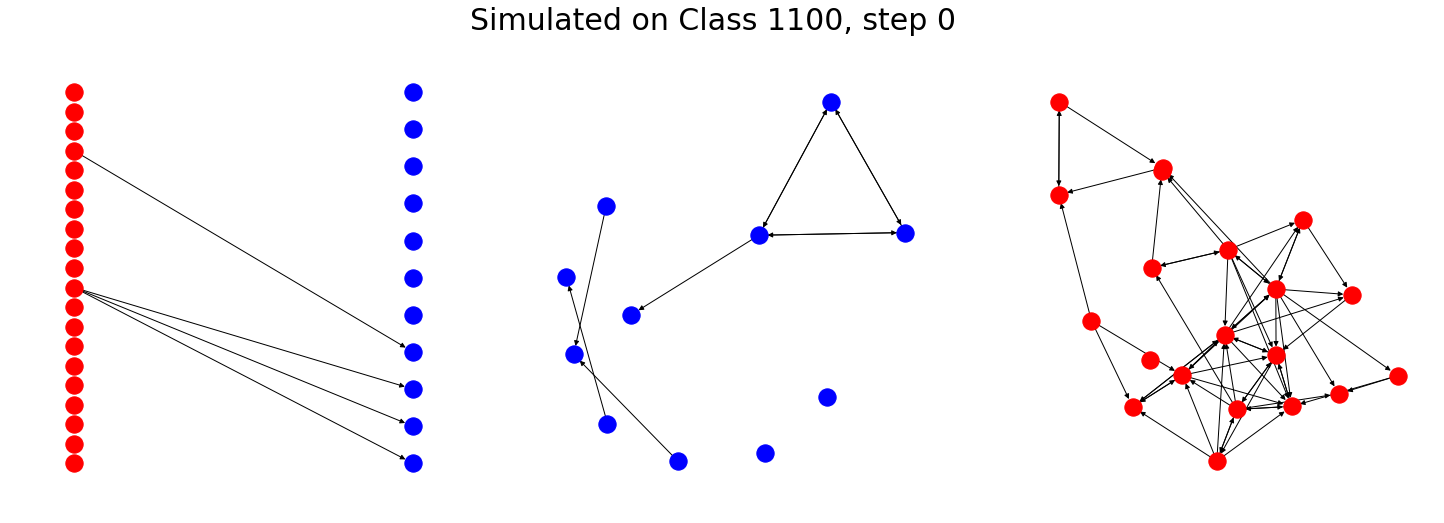

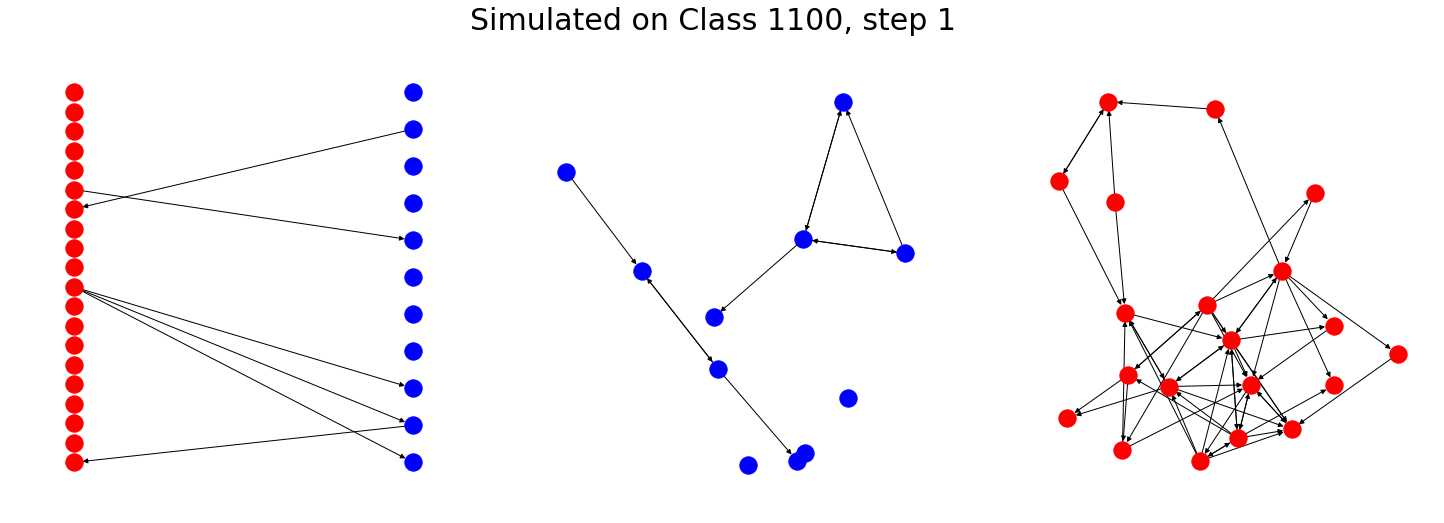

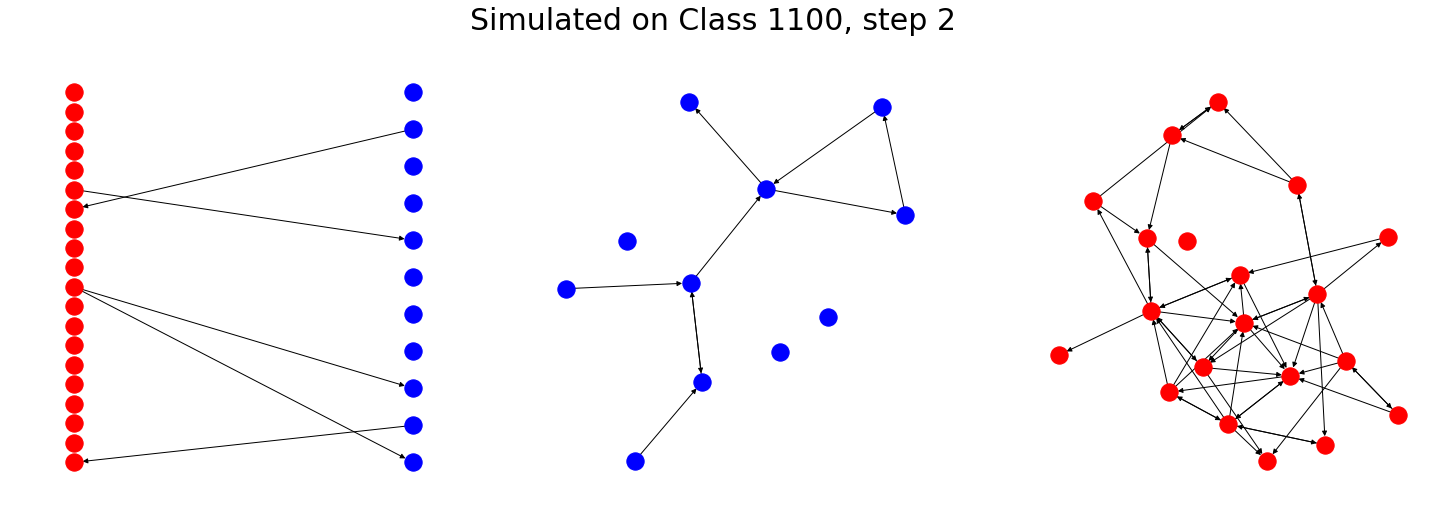

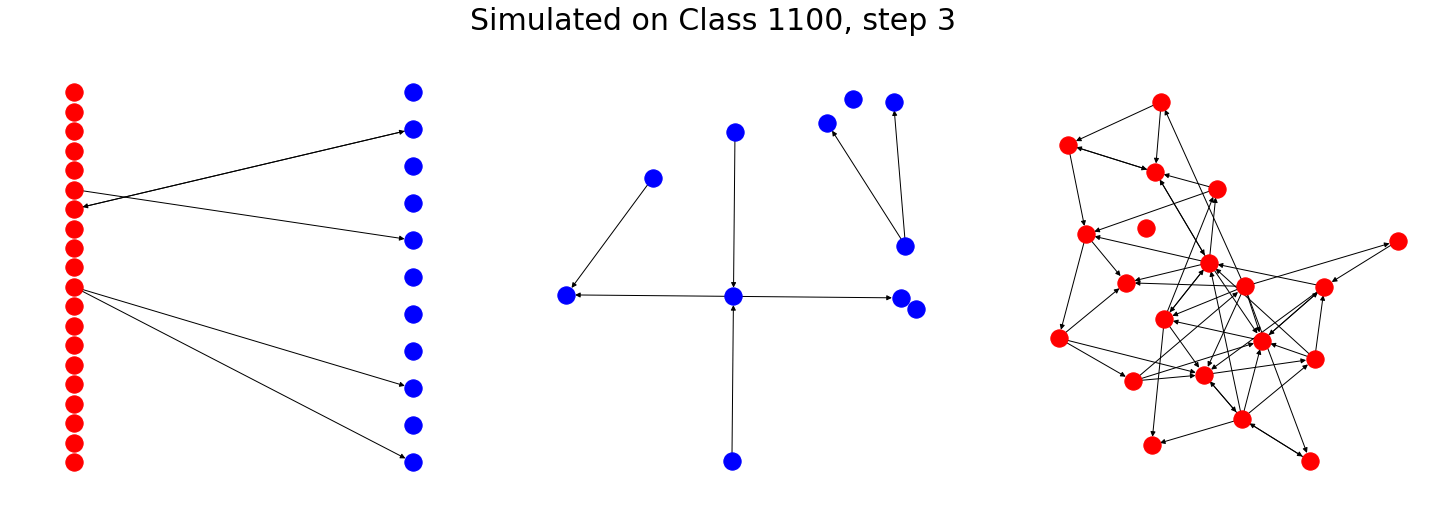

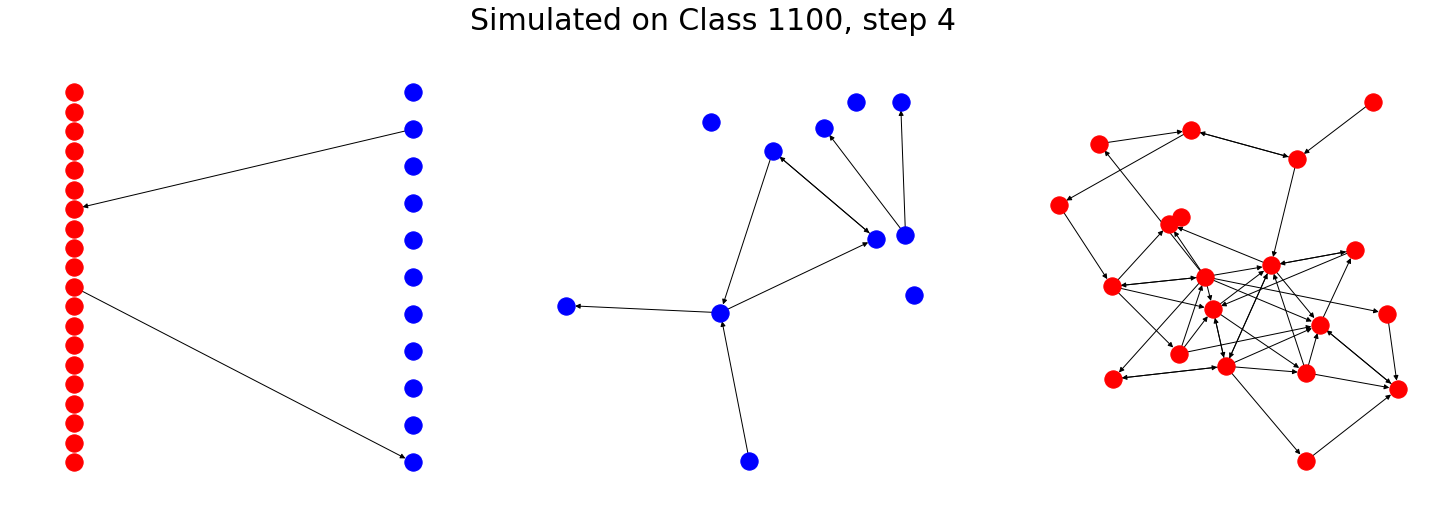

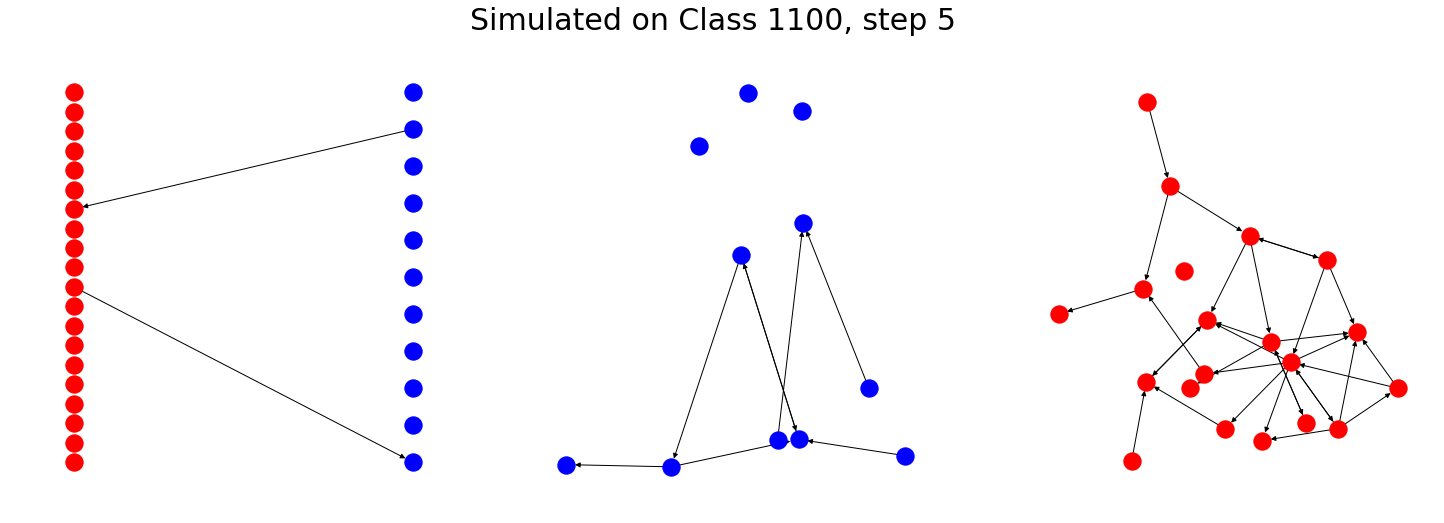

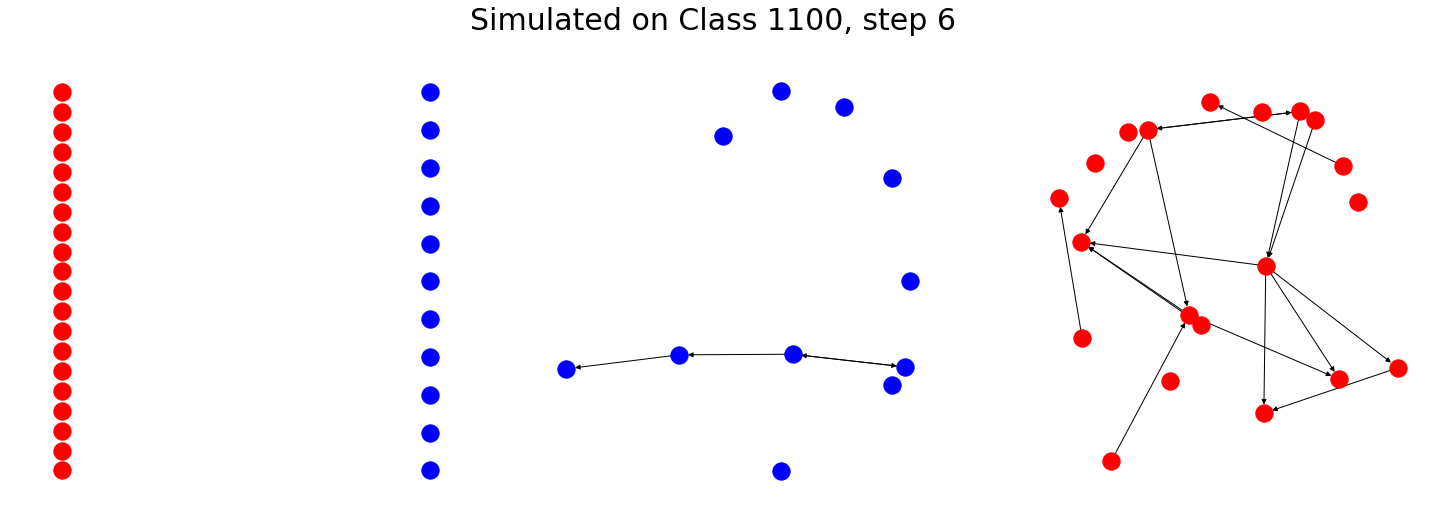

In [65]:
# Visualize a class in all steps
SELECTED_CLASS = 1100
for step in range(NUM_STEP + 1):
    visualize(simulated_networks[1100][step], SELECTED_CLASS, step)

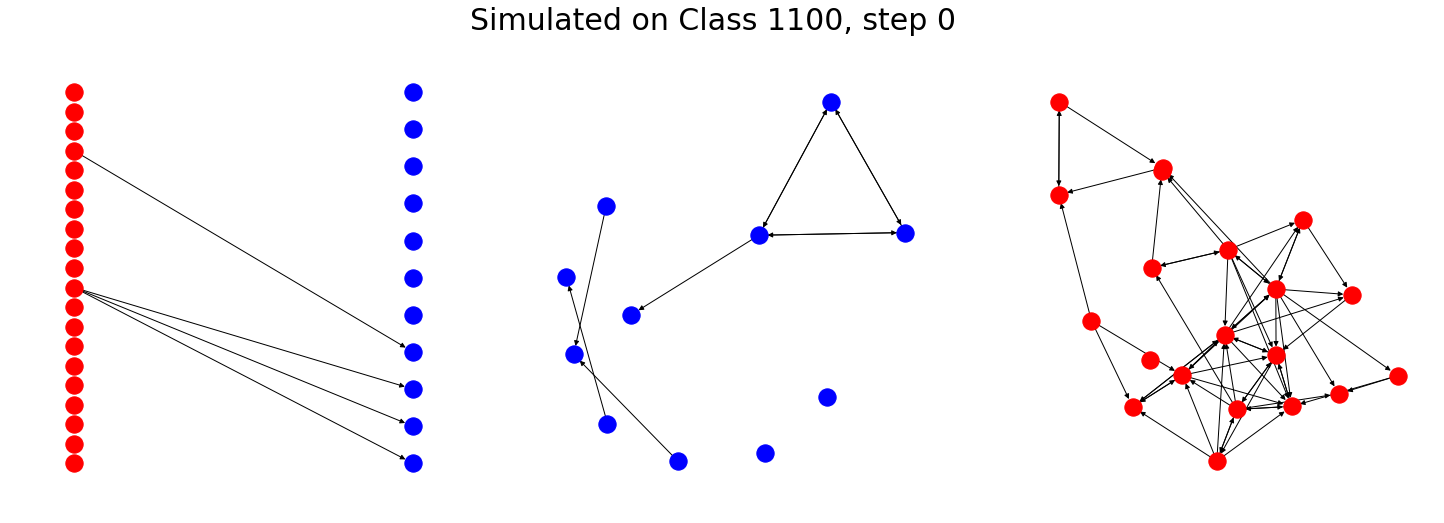

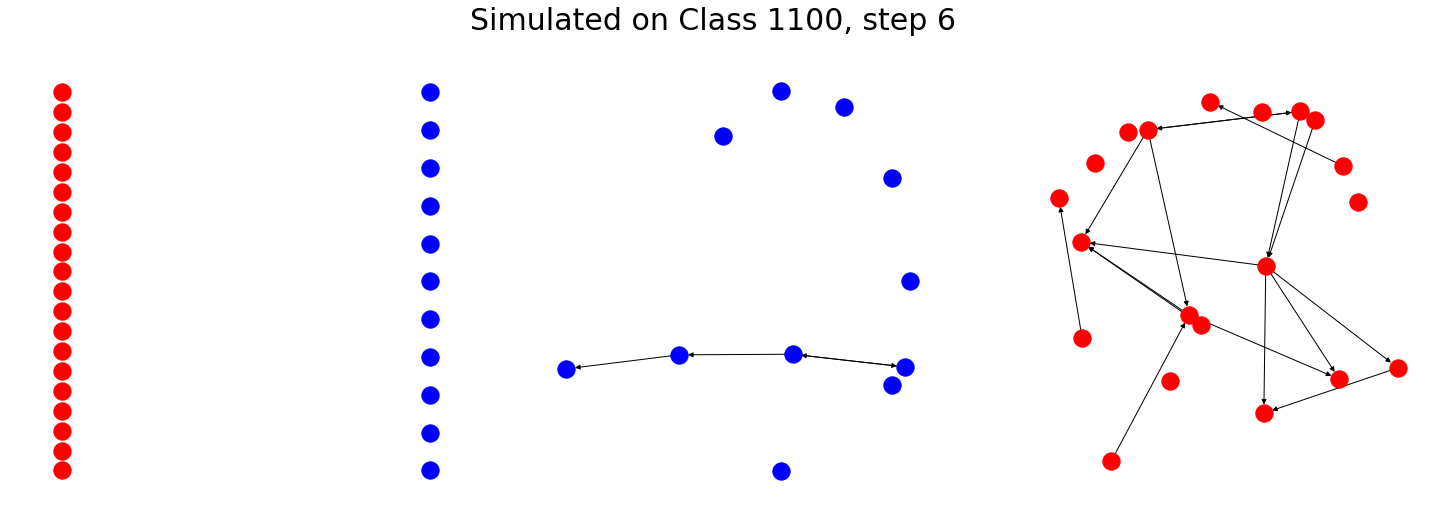

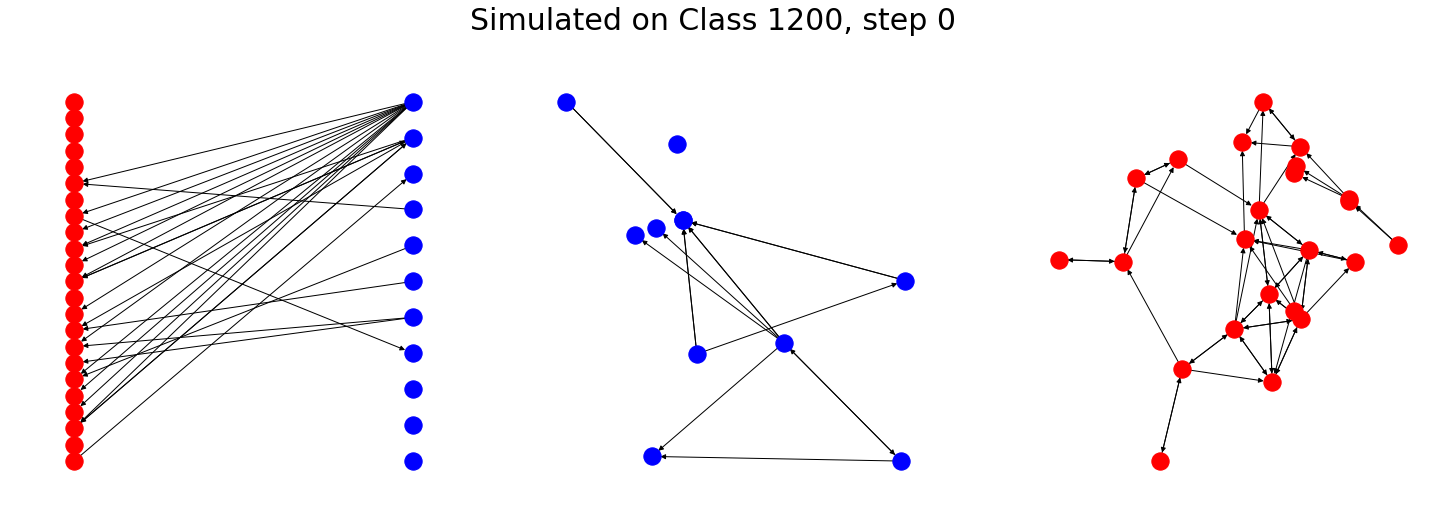

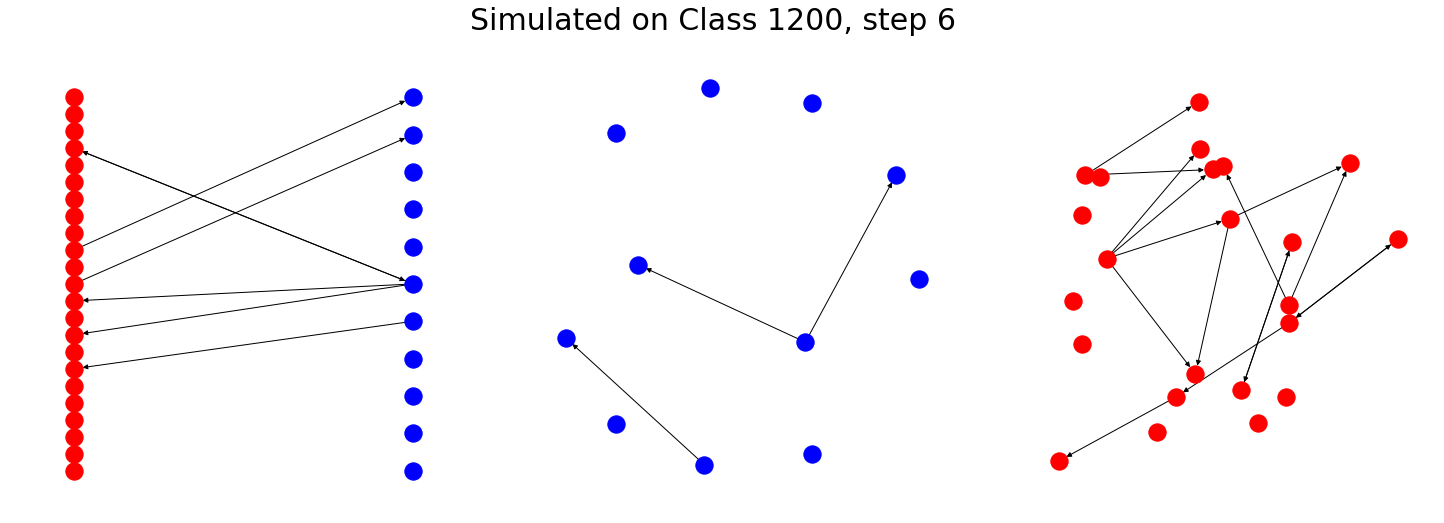

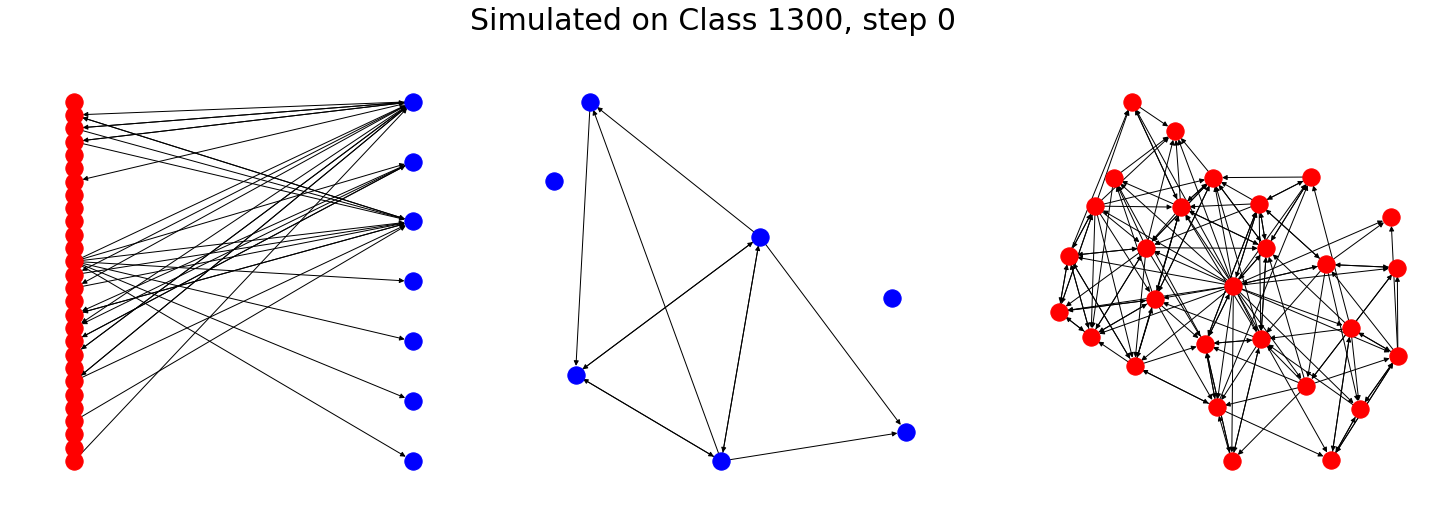

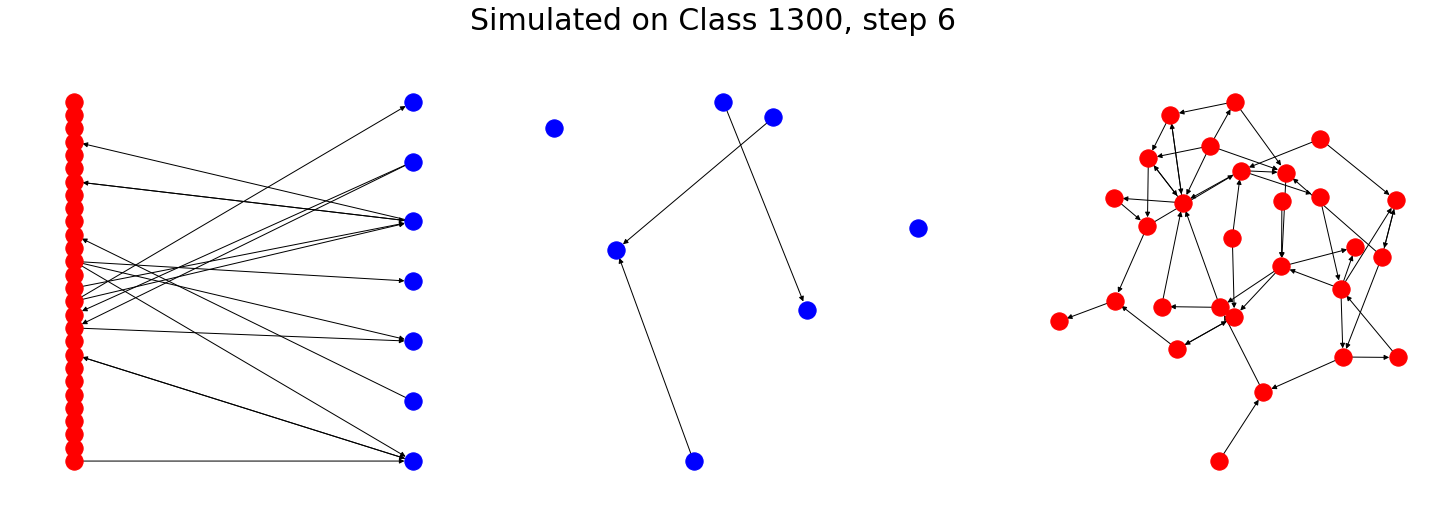

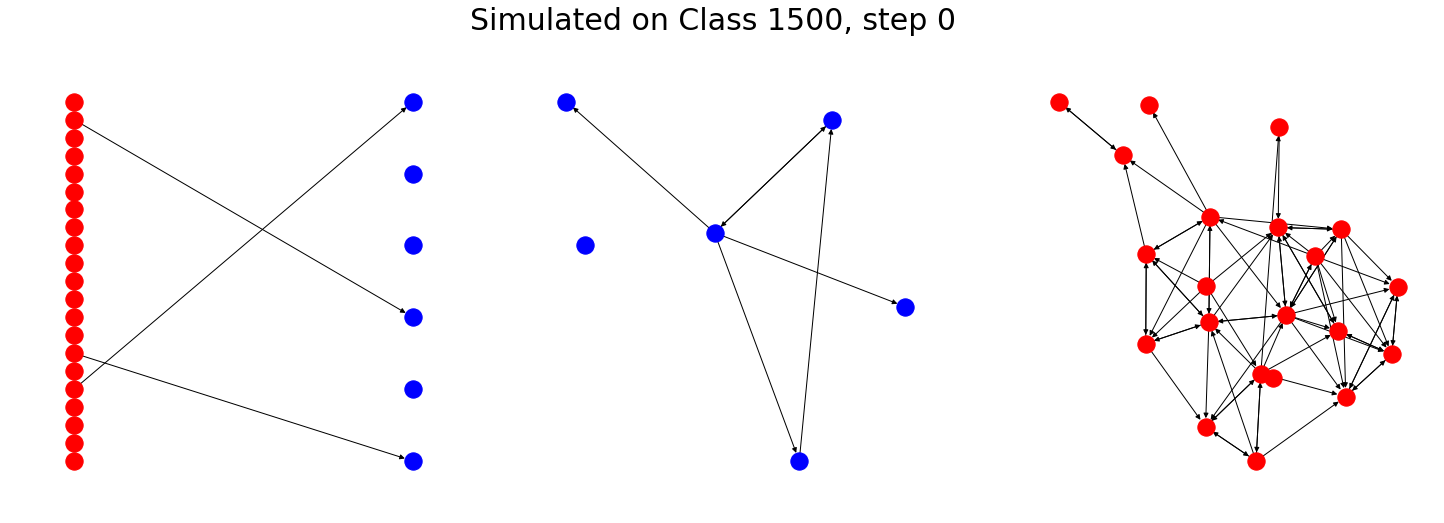

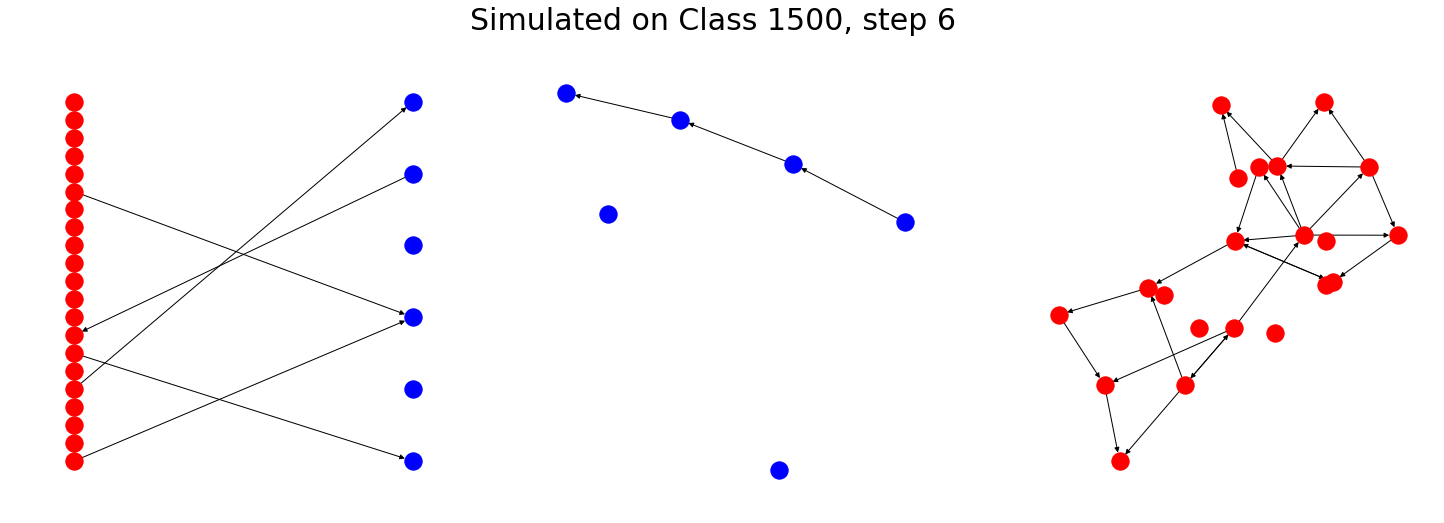

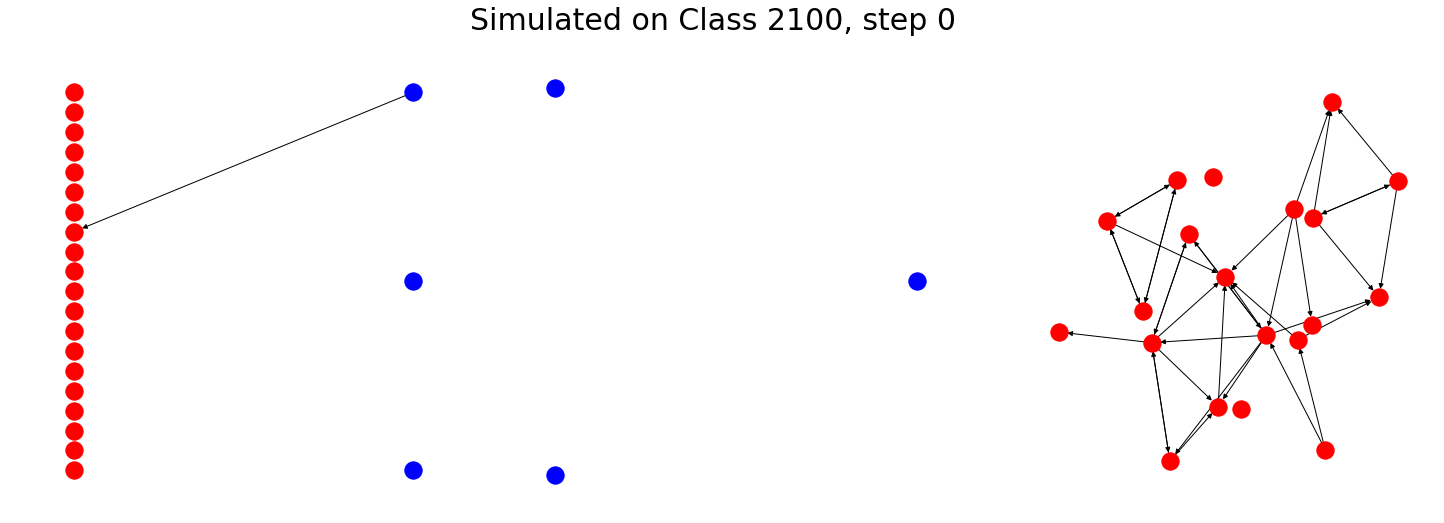

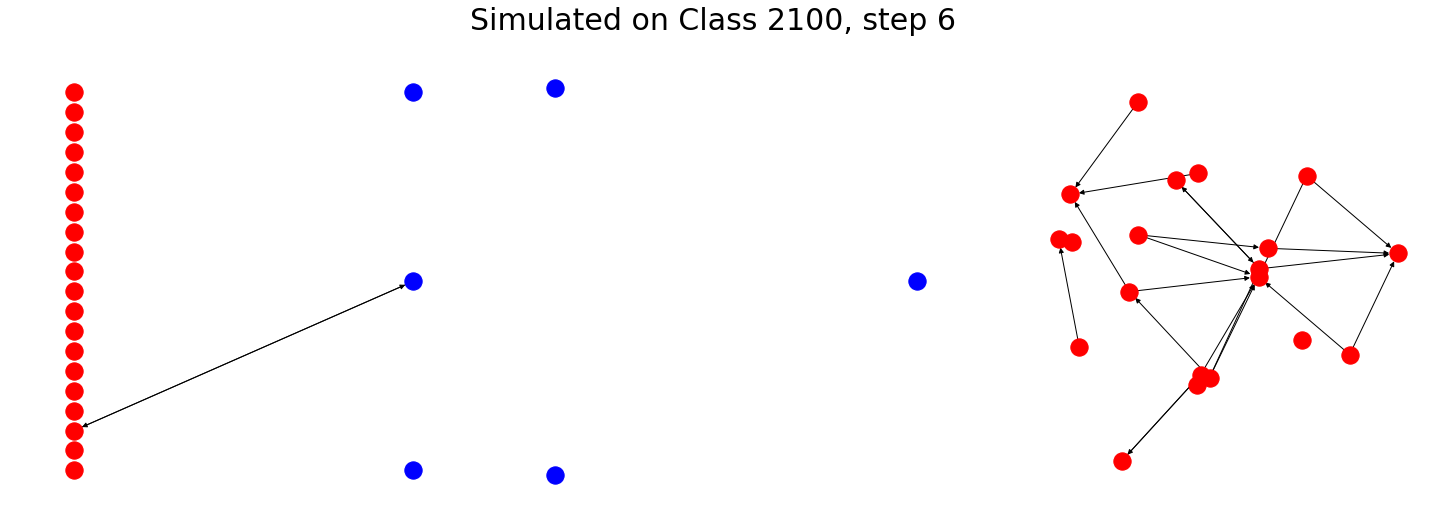

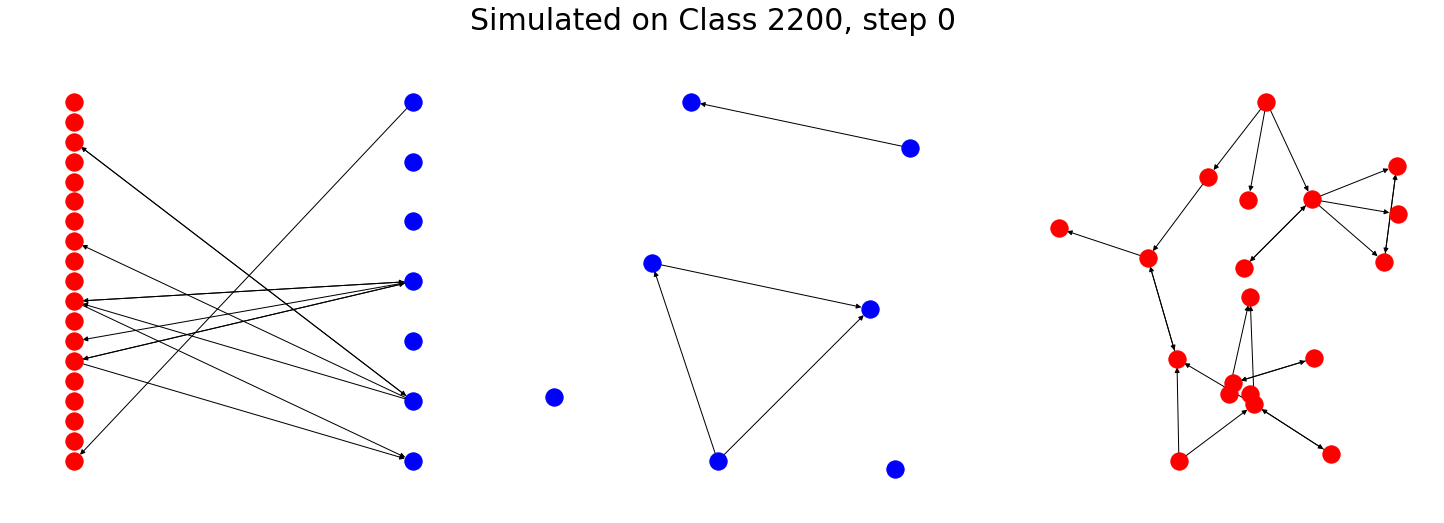

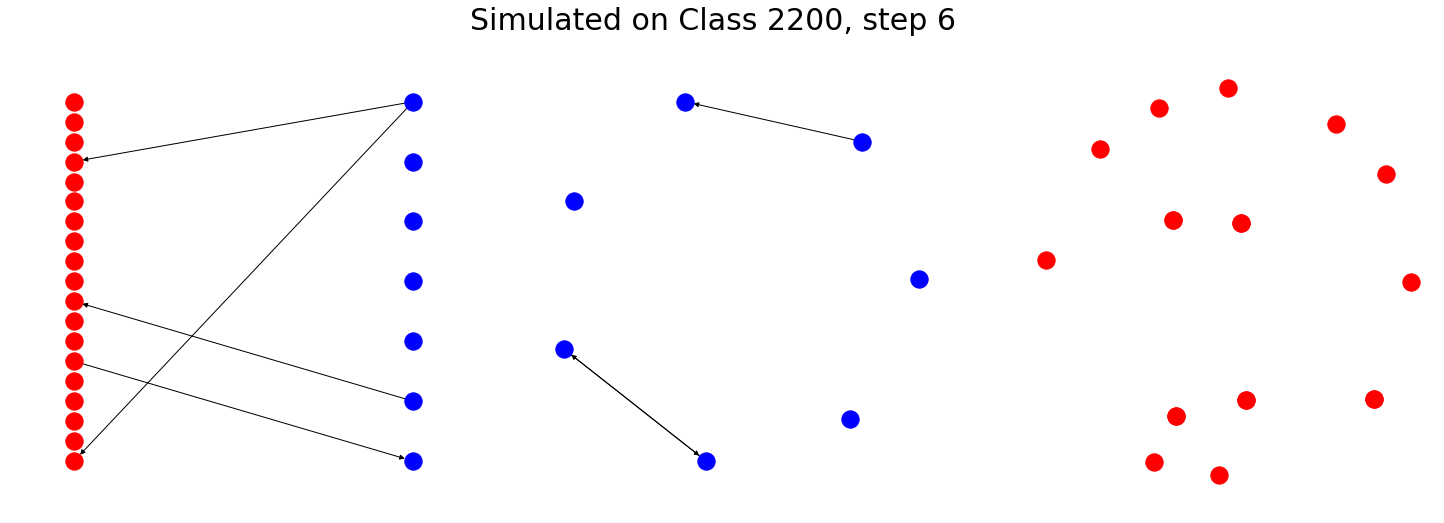

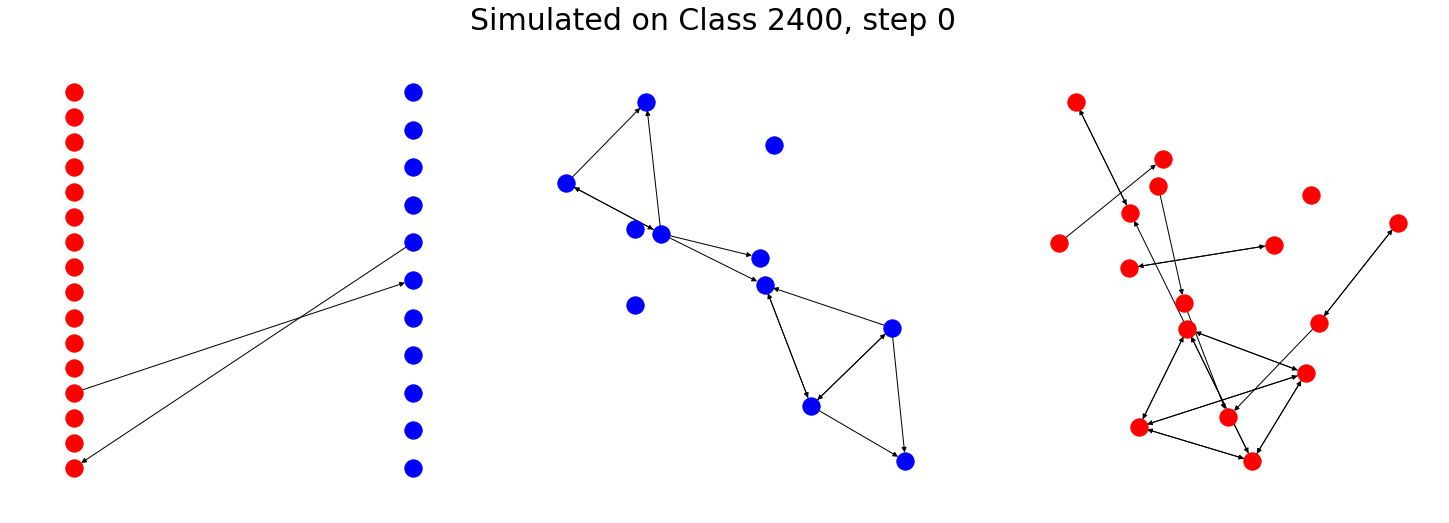

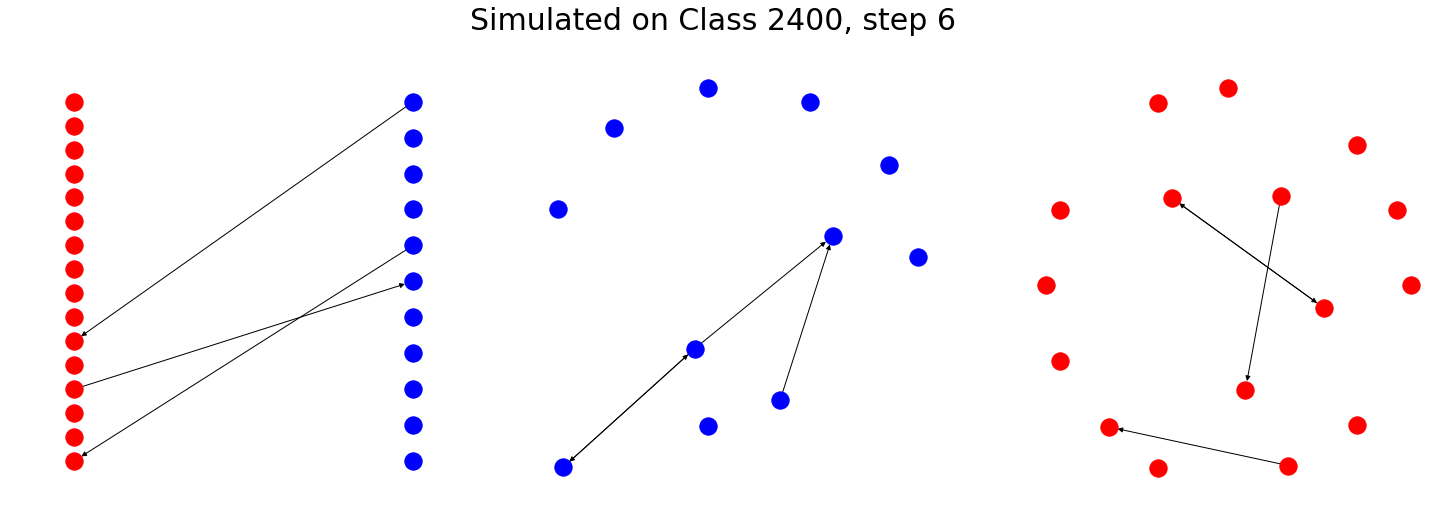

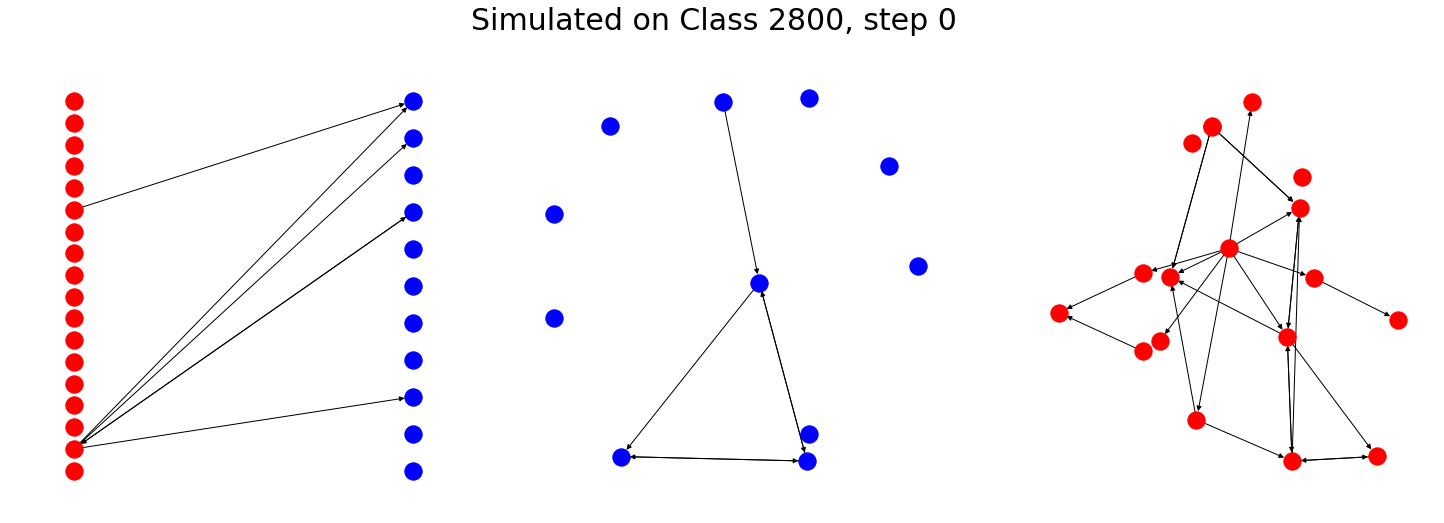

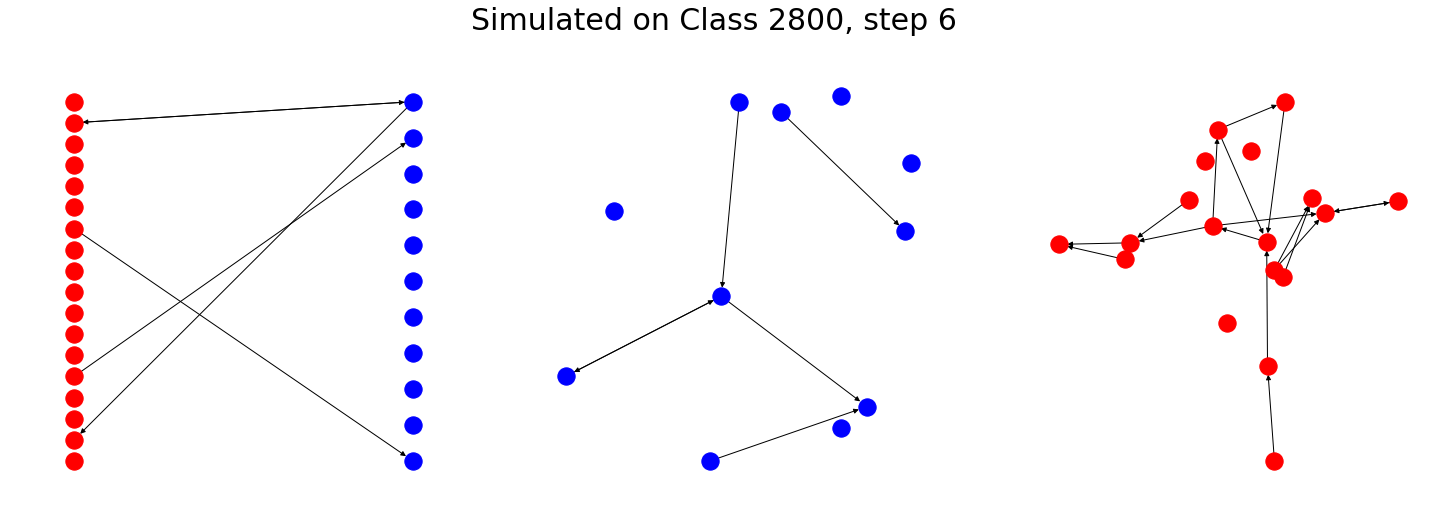

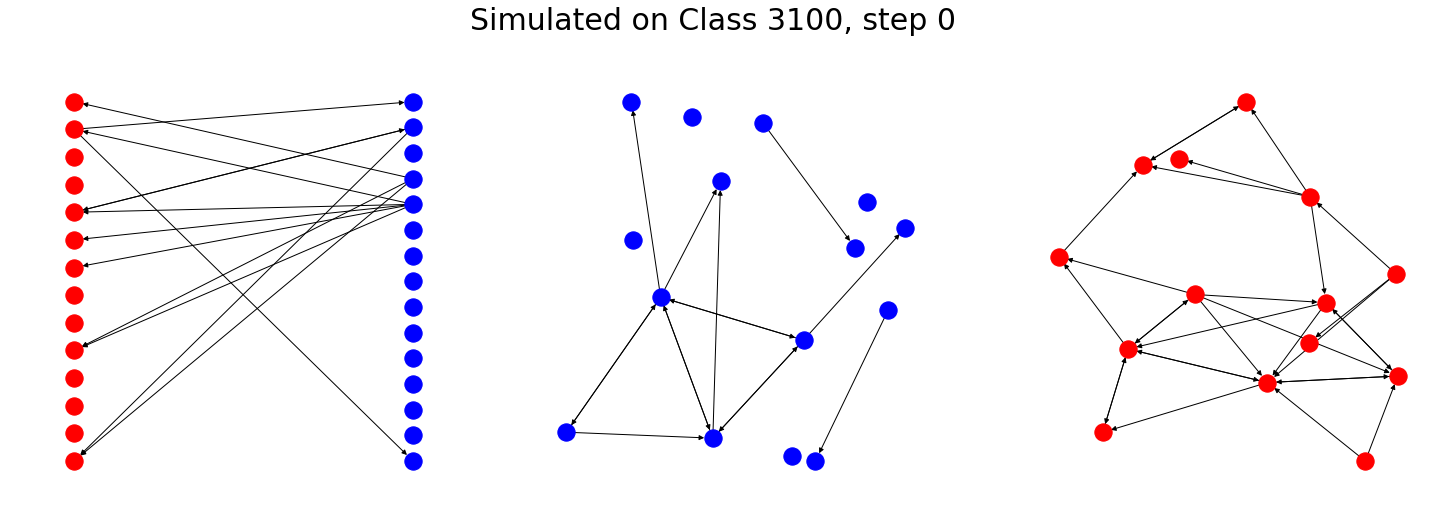

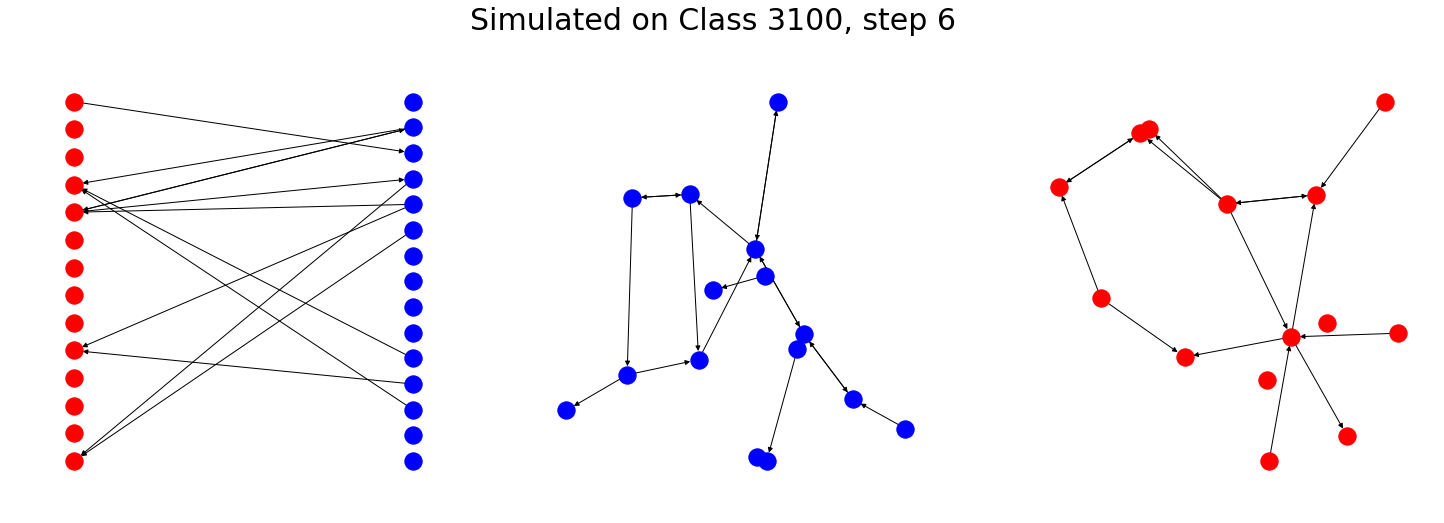

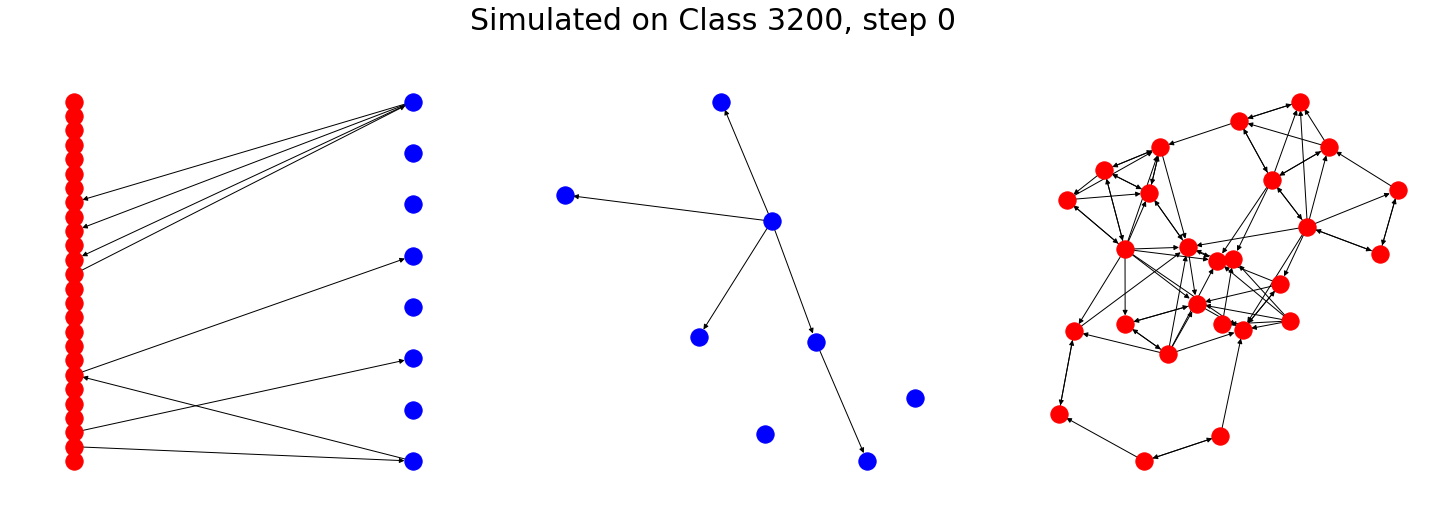

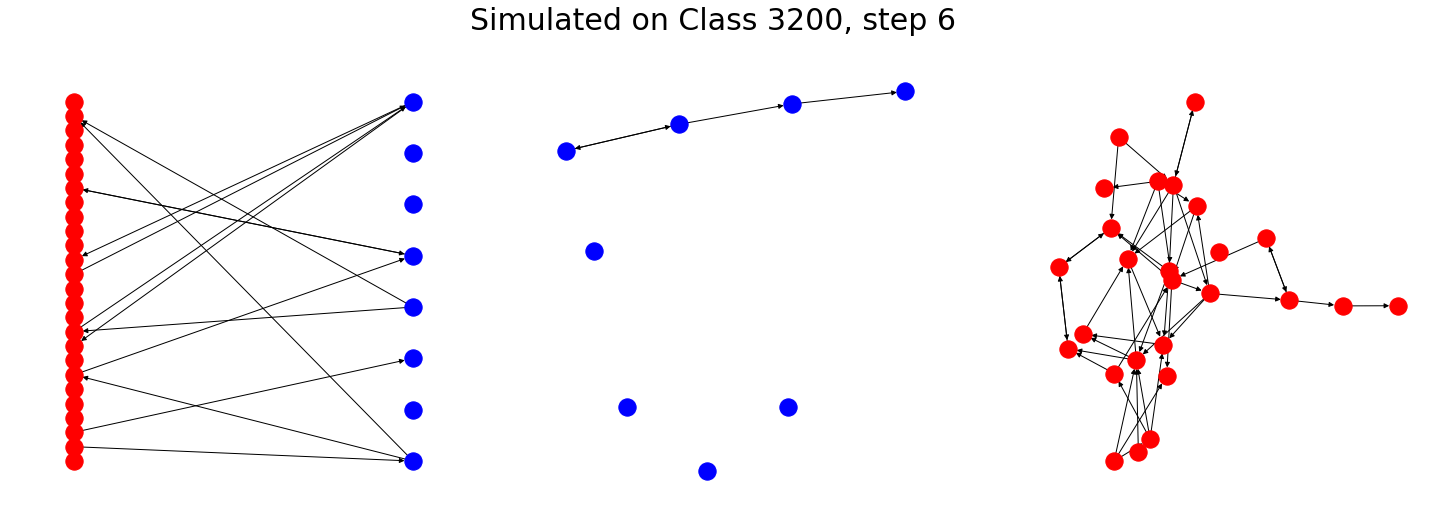

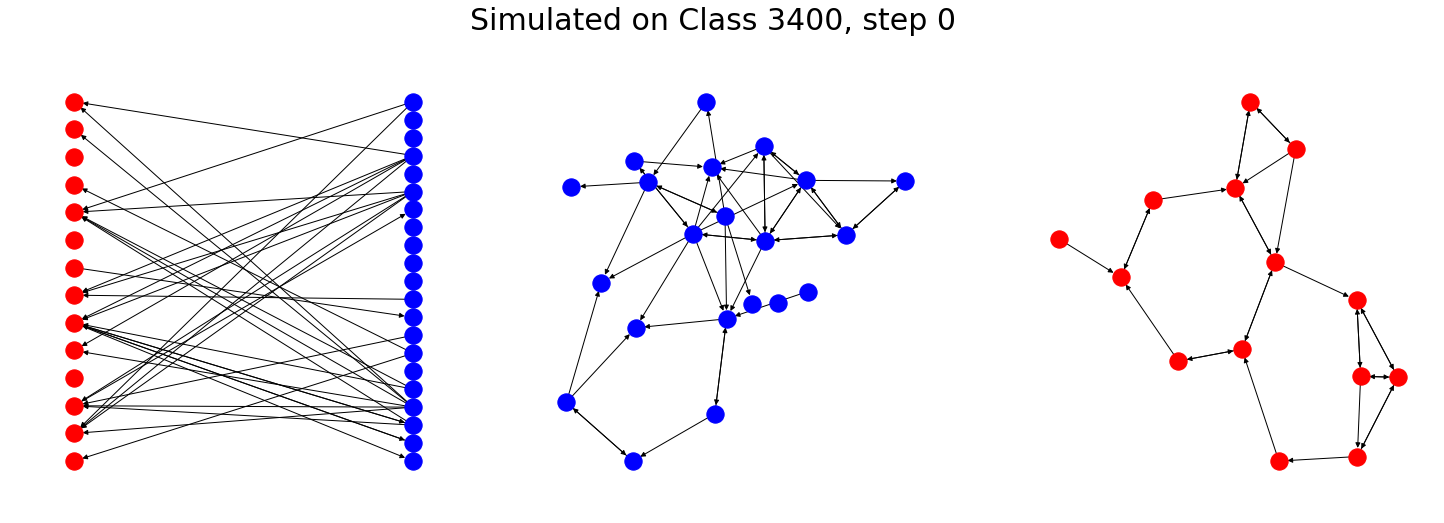

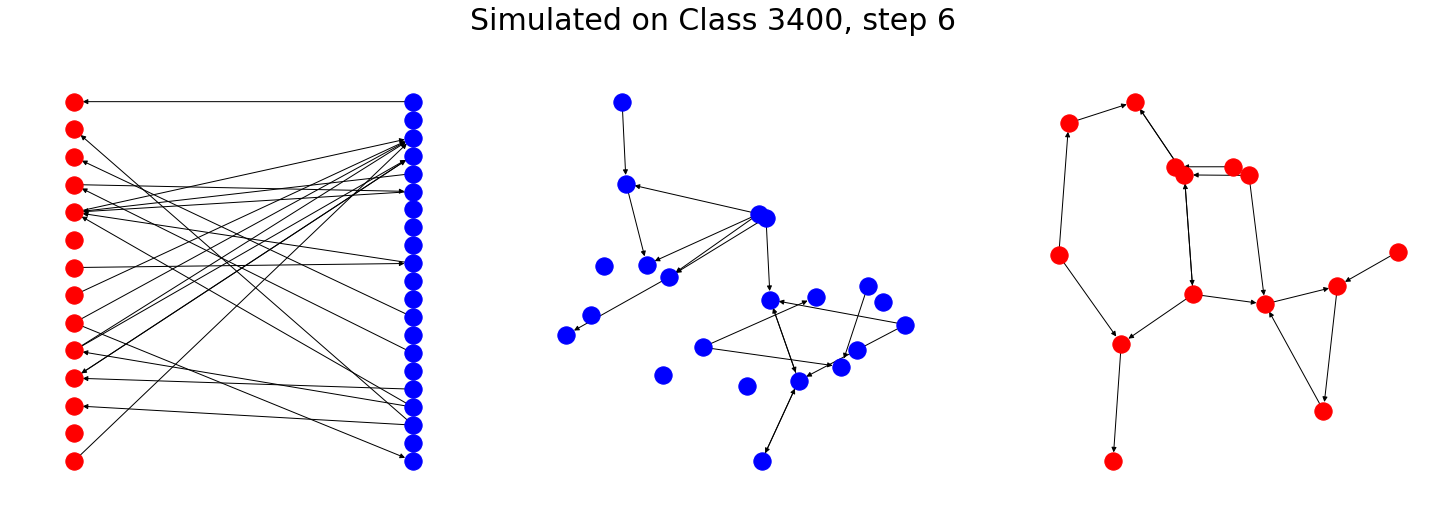

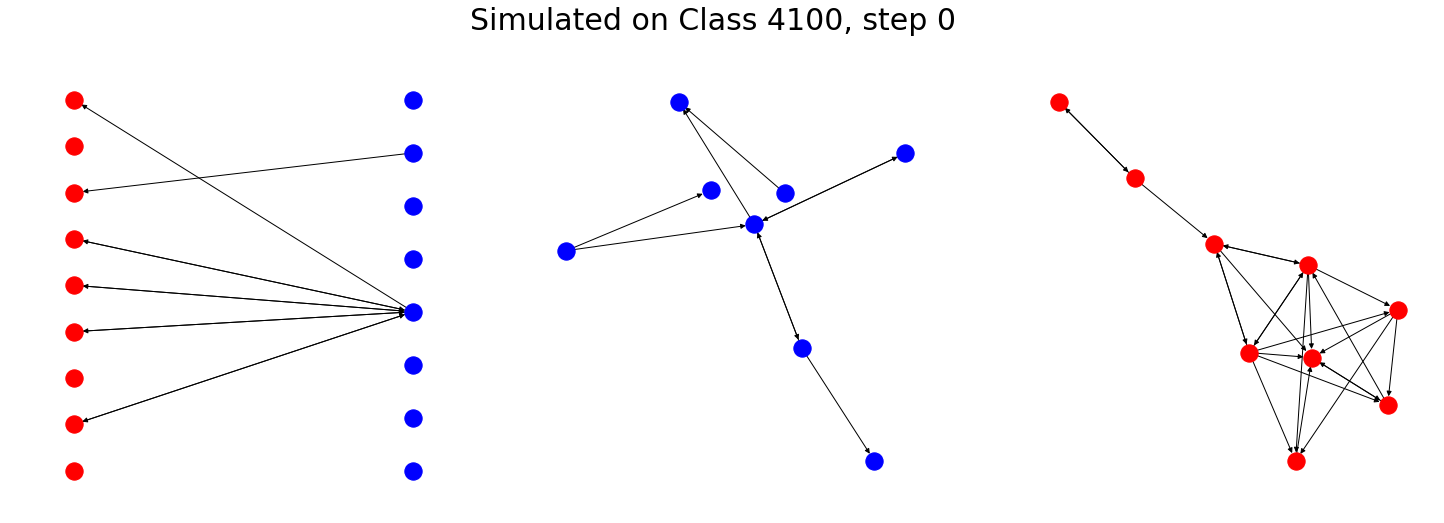

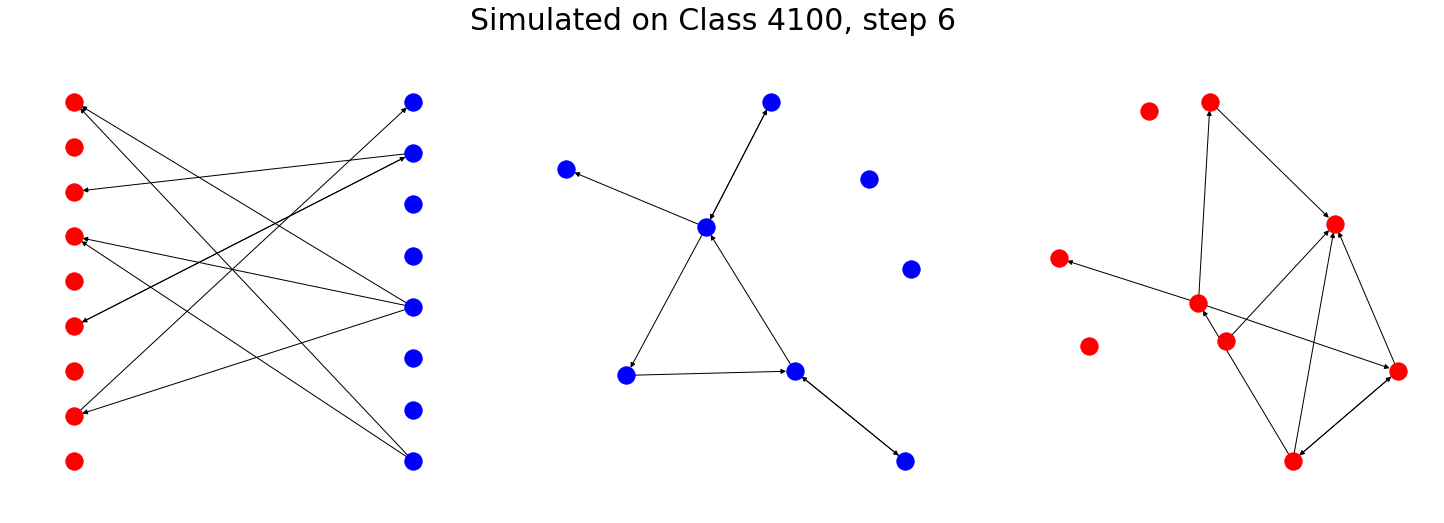

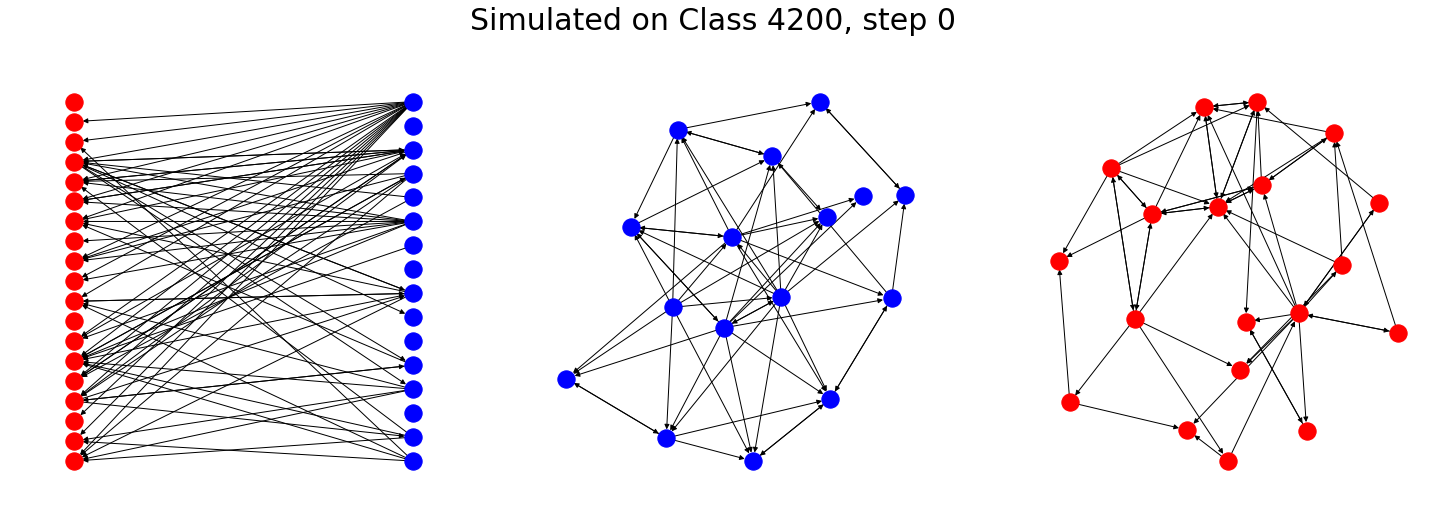

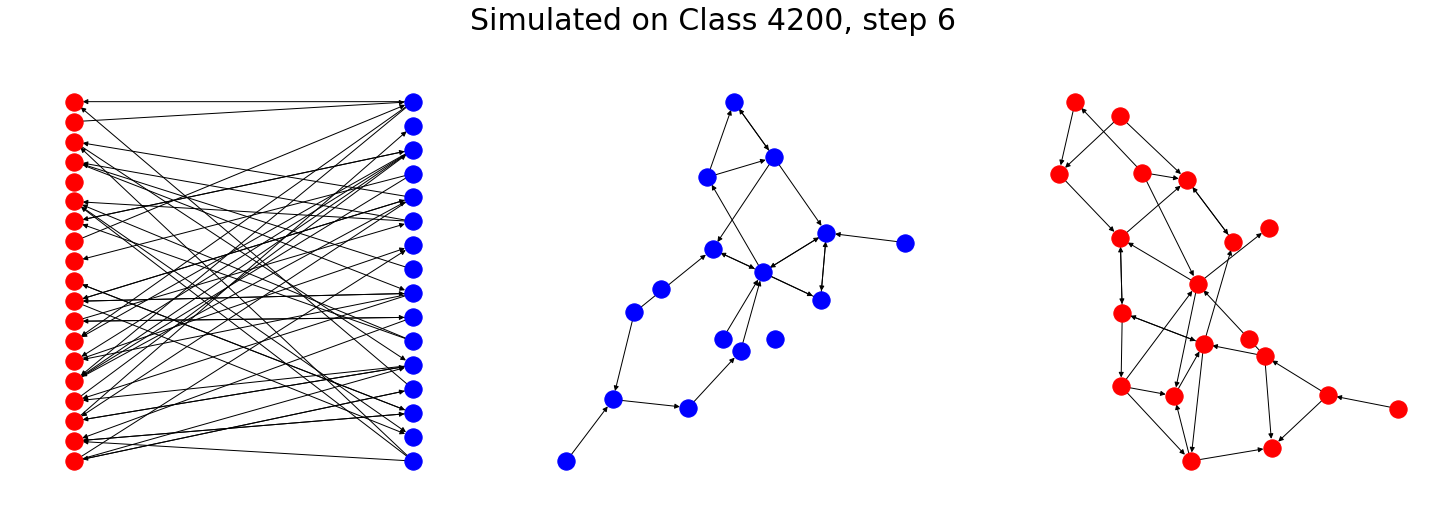

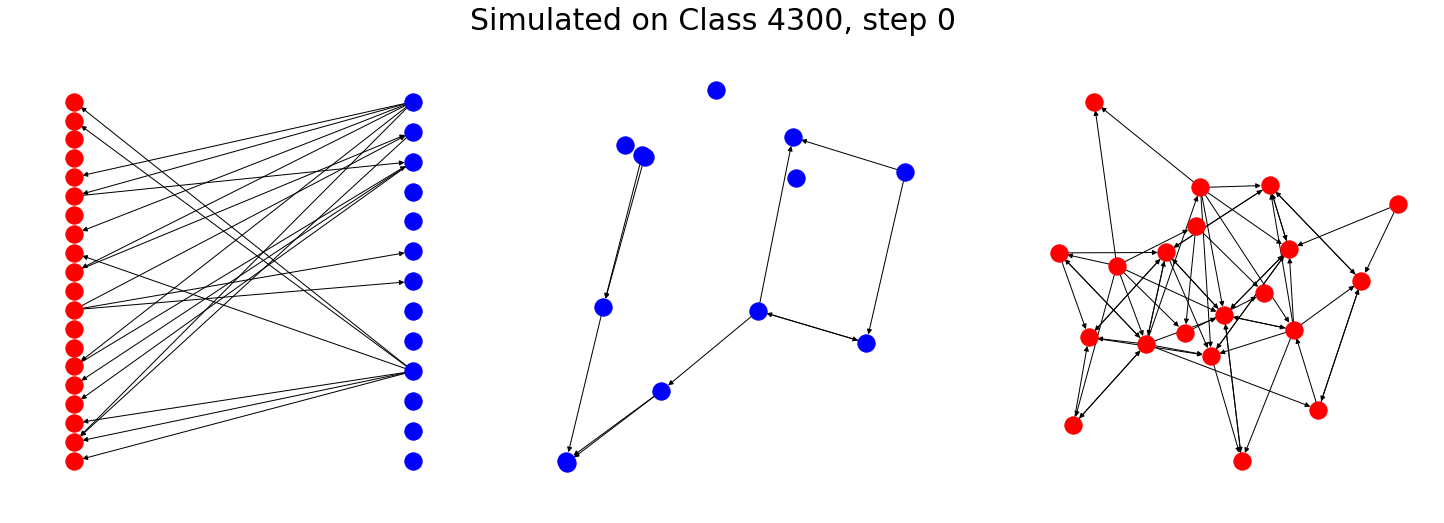

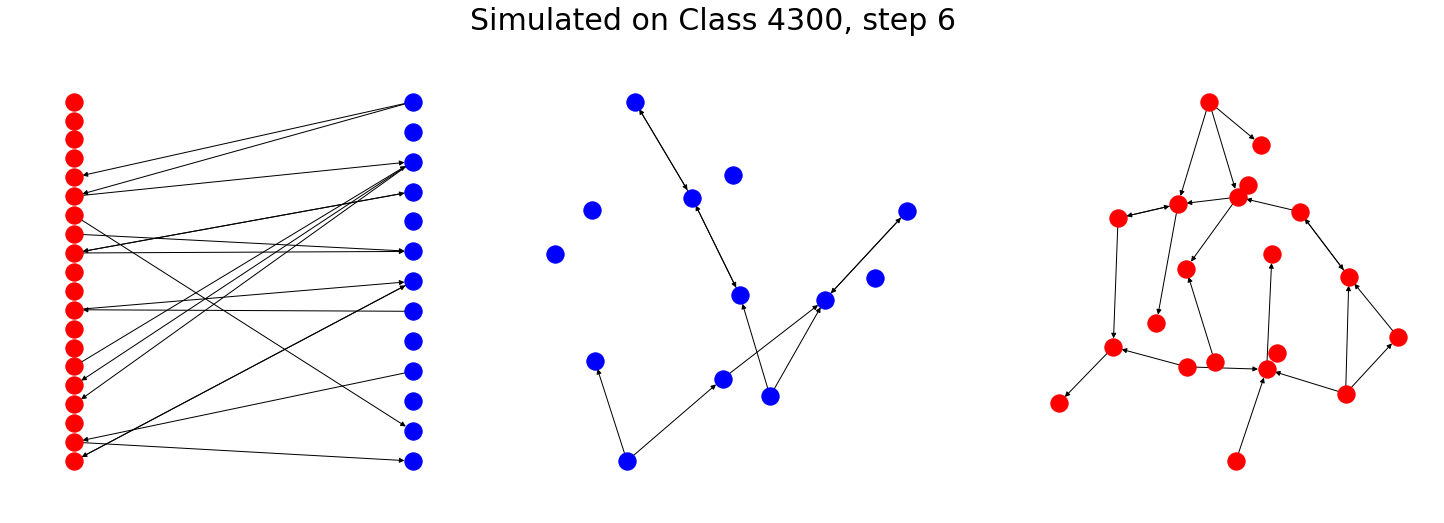

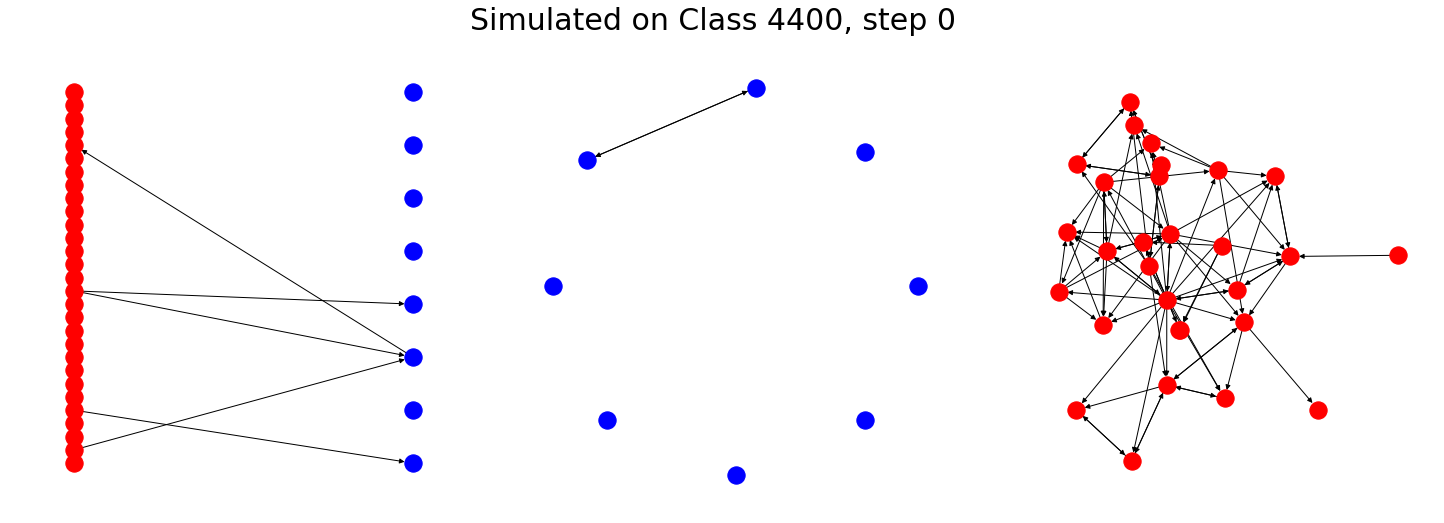

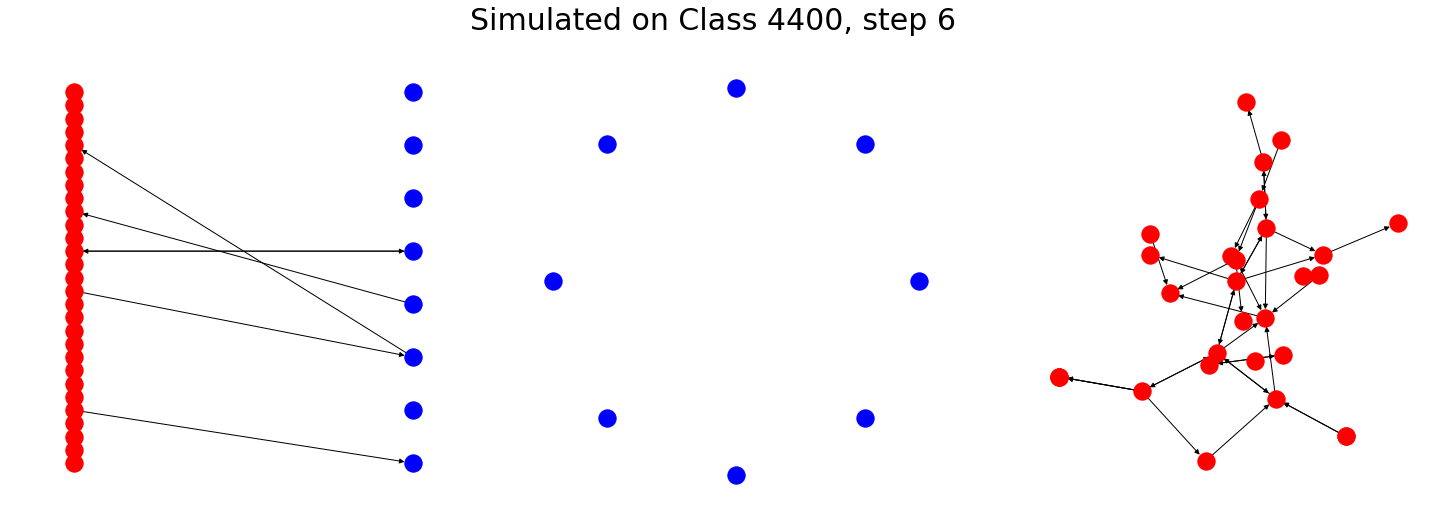

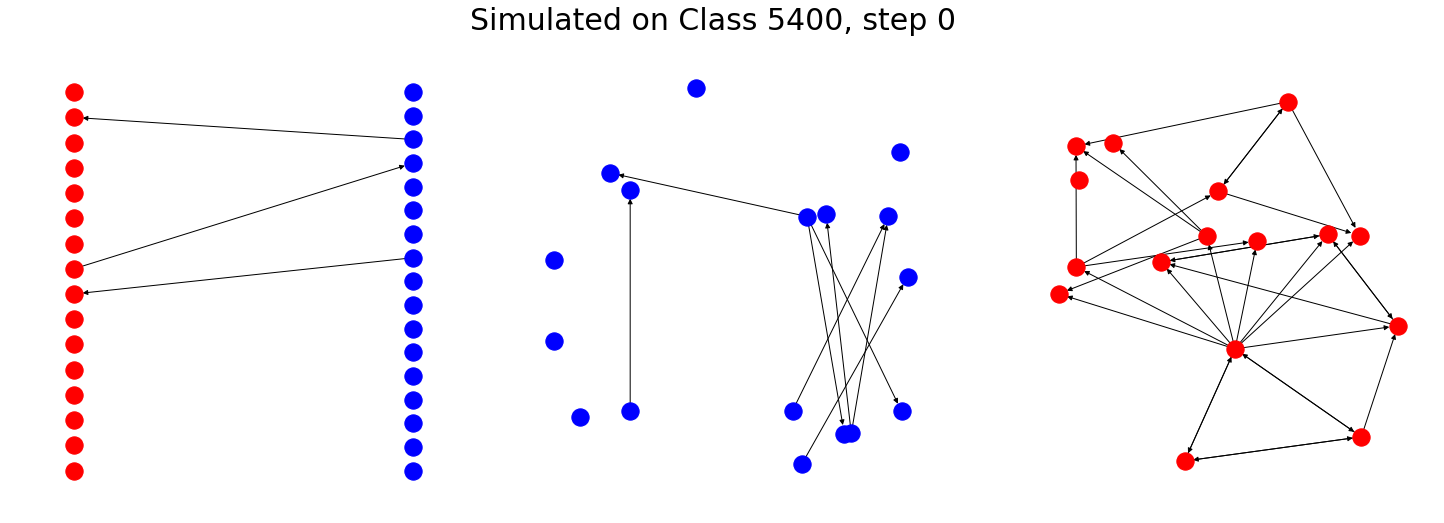

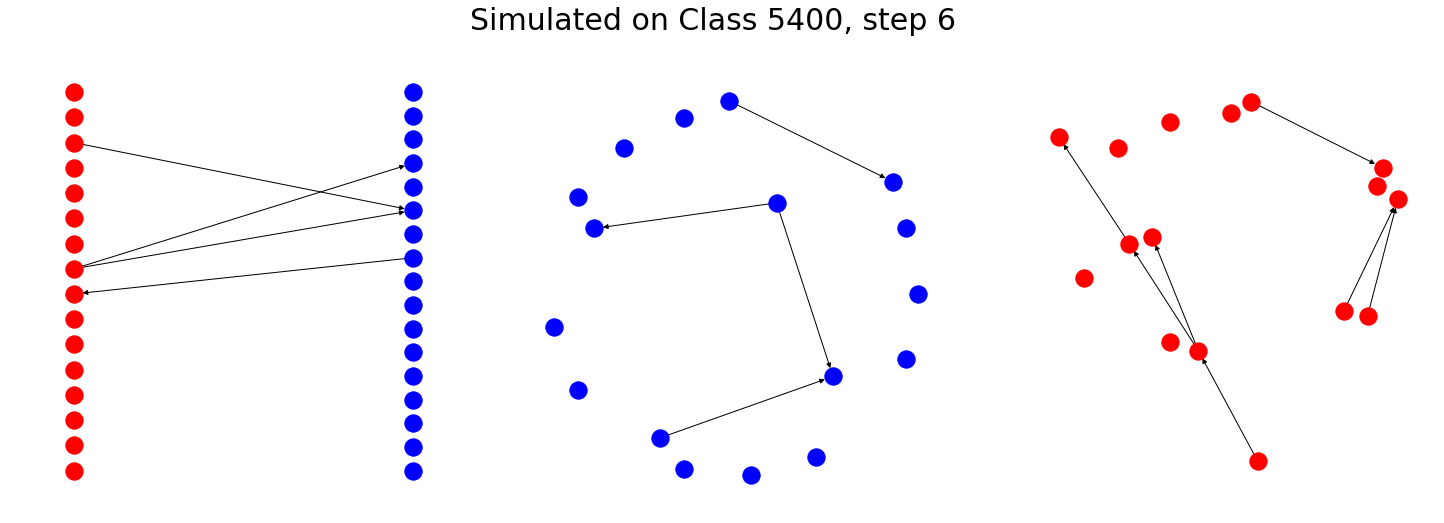

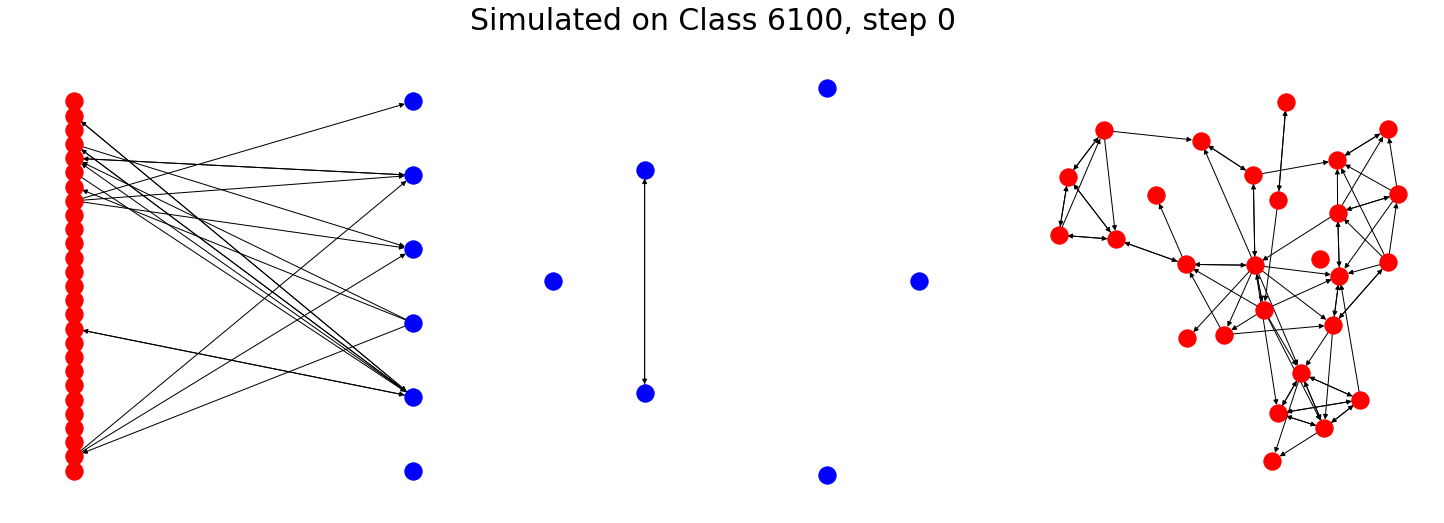

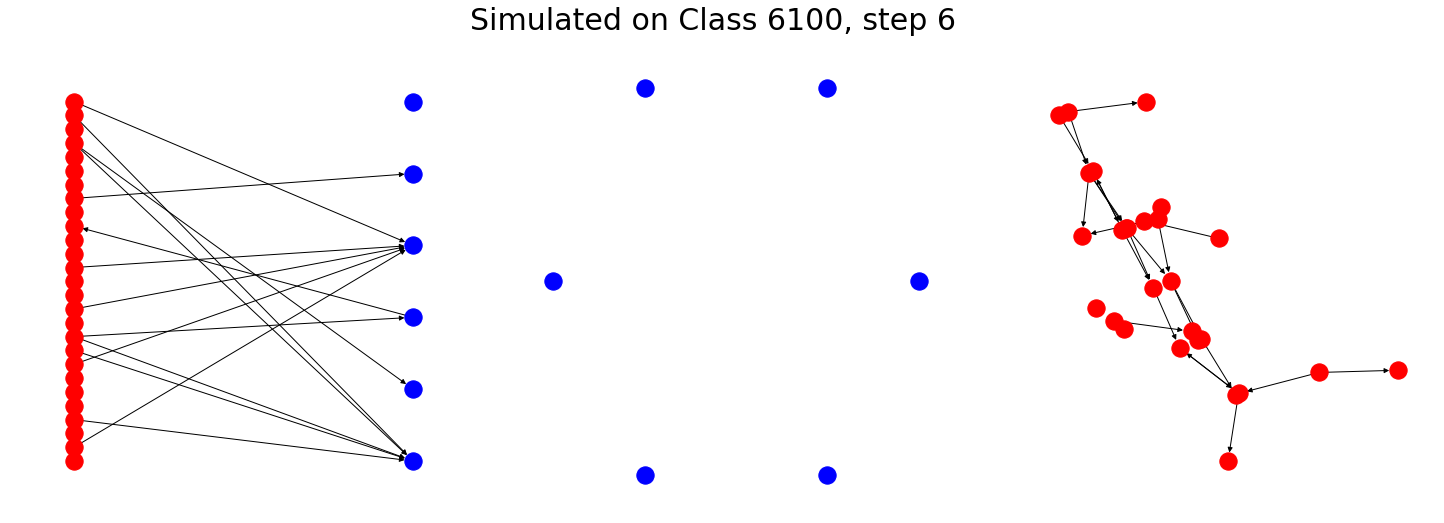

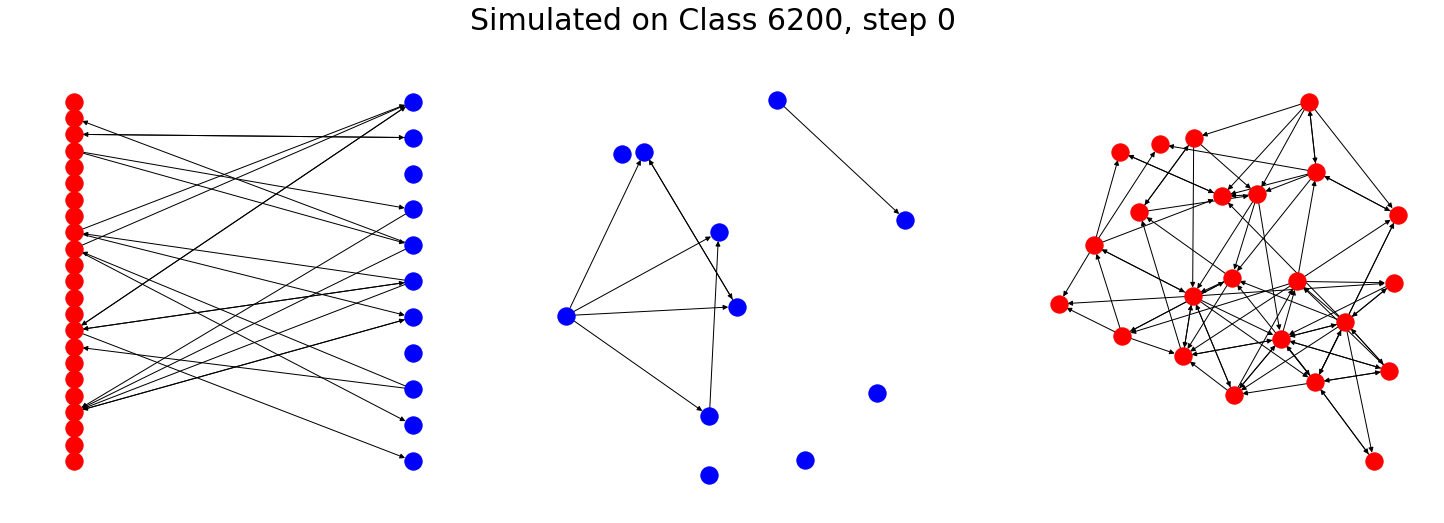

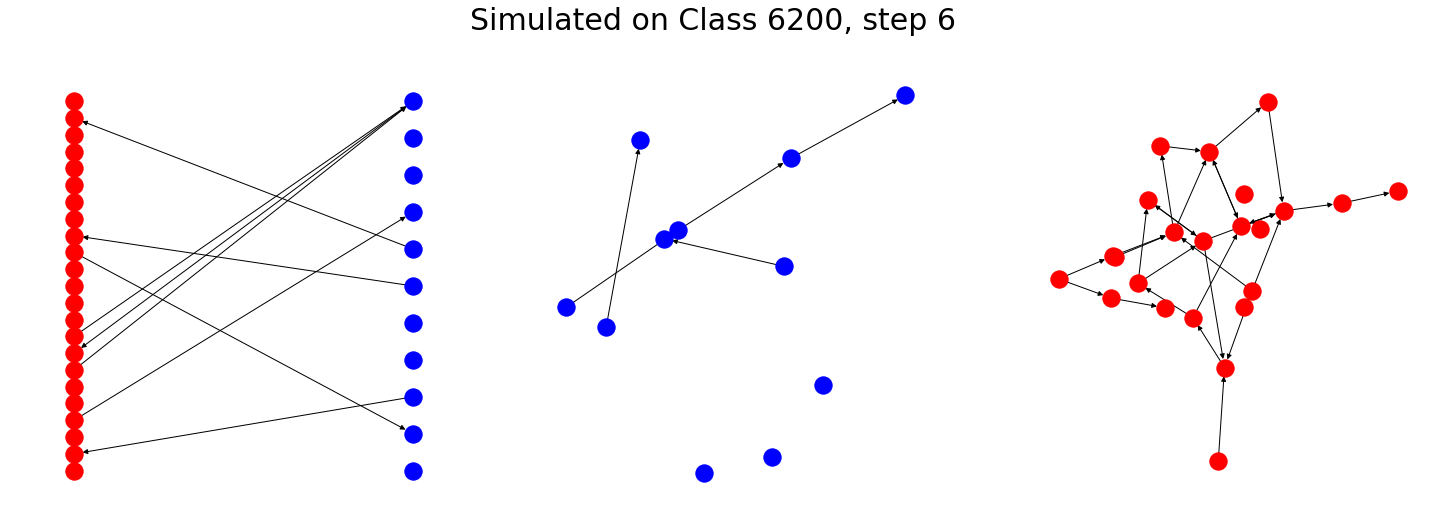

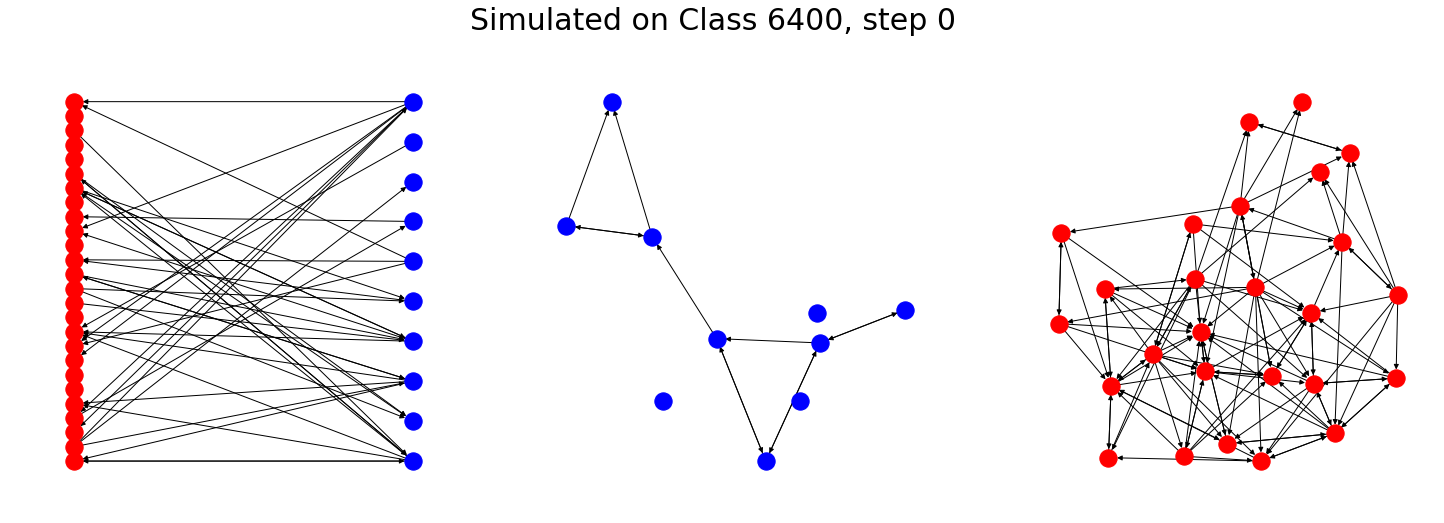

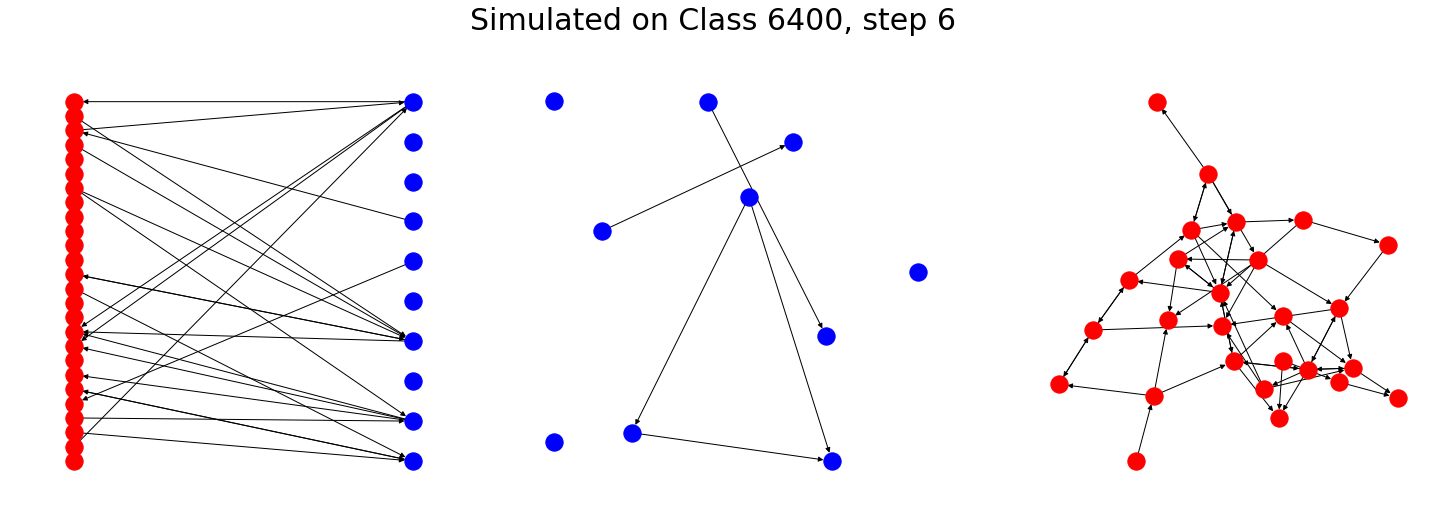

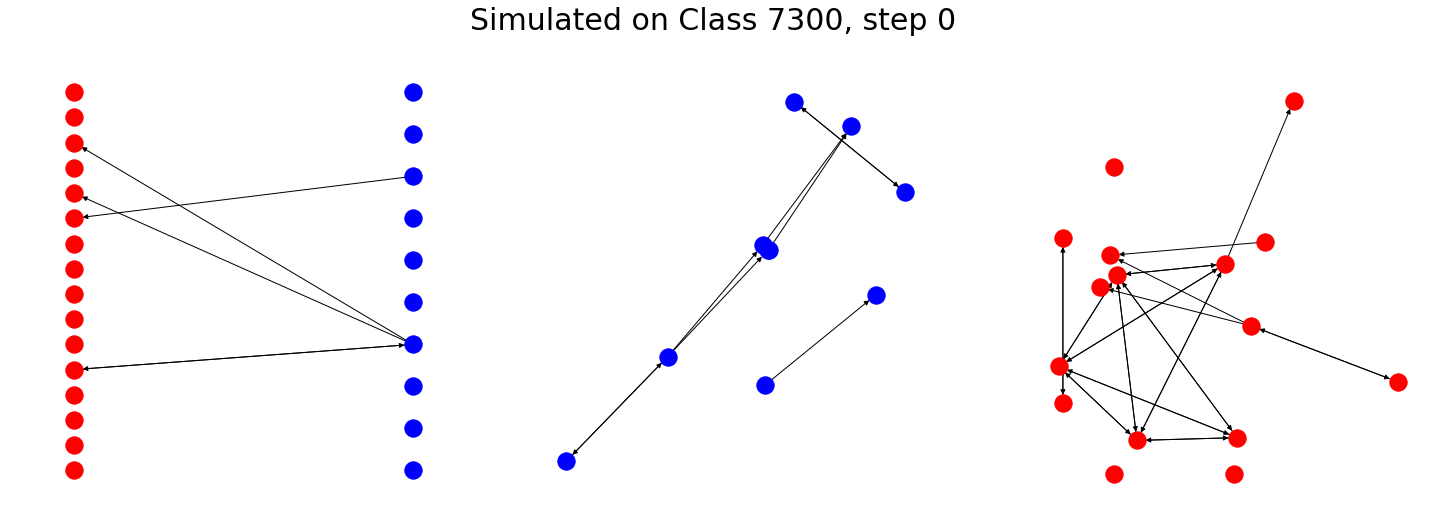

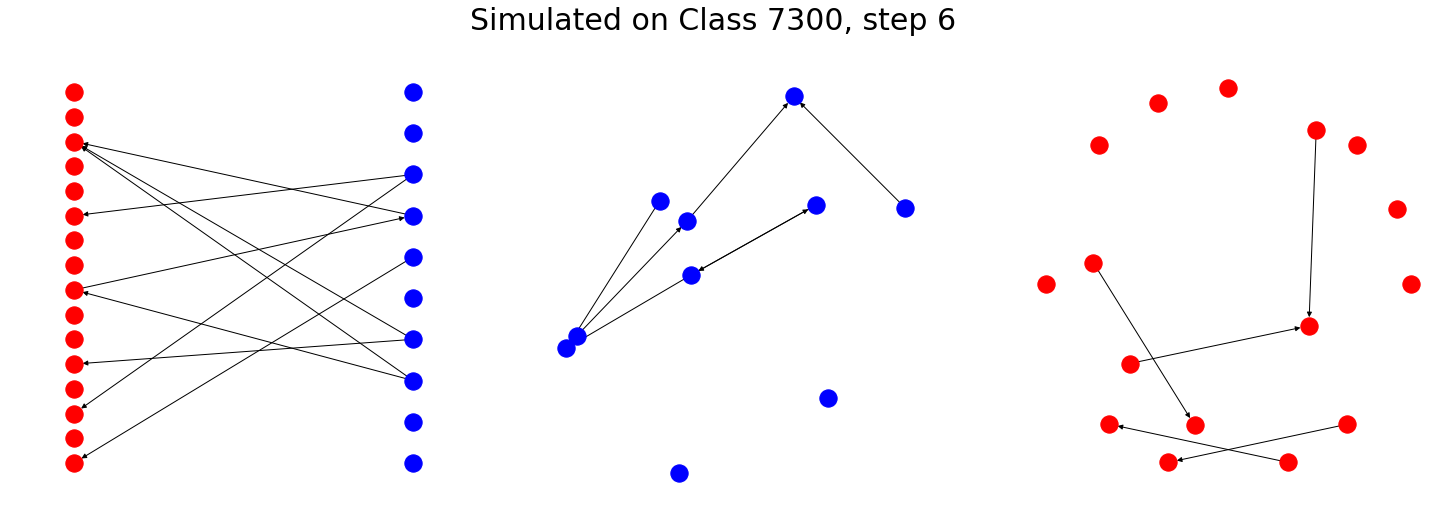

In [66]:
# Visualize all classes in step 0 and step #NUM_STEP
for class_id in class_ids:
    visualize(simulated_networks[class_id][0], class_id, 0)
    visualize(simulated_networks[class_id][NUM_STEP], class_id, NUM_STEP)